In [3]:
%load_ext autoreload
%autoreload 2
import pynwb
import os
import numpy as np

# DataJoint and DataJoint schema
import datajoint as dj

dj.config["filepath_checksum_size_limit"] = 1 * 1024**2

## We also import a bunch of tables so that we can call them easily
from spyglass.common import (
    ElectrodeGroup,
    Electrode,
    FirFilterParameters,
    IntervalList,
    Session,
    Task,
    TaskEpoch,
    Nwbfile,
    AnalysisNwbfile,
    NwbfileKachery,
    AnalysisNwbfileKachery,
    interval_list_contains,
    interval_list_contains_ind,
    interval_list_excludes,
    interval_list_excludes_ind,
    interval_list_intersect,
    get_electrode_indices,
)

from spyglass.lfp.v1 import (
    LFPElectrodeGroup,
    LFPSelection,
    LFPV1,
)
from spyglass.lfp.lfp_merge import LFPOutput


from spyglass.lfp.analysis.v1.lfp_band import LFPBandSelection,LFPBandV1
# from spyglass.lfp_band.lfp_band_merge import LFPBandOutput
import os
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.simplefilter("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Animal Sessions

In [2]:
nwb_file_names = [
    #Olive
    "Olive20220624_.nwb",
    "Olive20220627_.nwb",
    "Olive20220628_.nwb",
    "Olive20220629_.nwb",
    "Olive20220630_.nwb",
    "Olive20220701_.nwb",
    "Olive20220702_.nwb",
    "Olive20220705_.nwb",
    "Olive20220706_.nwb",
    #Yoshi
    "Yoshi20220509_.nwb",
    "Yoshi20220510_.nwb",
    "Yoshi20220511_.nwb",
    "Yoshi20220519_.nwb",
    "Yoshi20220525_.nwb",
    #Winnie
    "Winnie20220712_.nwb",
    "Winnie20220713_.nwb",
    "Winnie20220714_.nwb",
    "Winnie20220715_.nwb",
    "Winnie20220716_.nwb",
    #Wallie
    "Wallie20220911_.nwb",
    "Wallie20220912_.nwb",
    "Wallie20220913_.nwb",
    "Wallie20220916_.nwb",
    #Totoro
    "Totoro20220524_.nwb",
    "Totoro20220525_.nwb",
    "Totoro20220526_.nwb",
    "Totoro20220527_.nwb",
    "Totoro20220530_.nwb",
    "Totoro20220531_.nwb",
    "Totoro20220602_.nwb",
    "Totoro20220603_.nwb",
    "Totoro20220606_.nwb",
    "Totoro20220621_.nwb",
    #Odins
    "Odins20220107_.nwb",
    "Odins20220110_.nwb",
    "Odins20220111_.nwb",
    "Odins20220113_.nwb",
    "Odins20220118_.nwb",
    "Odins20220119_.nwb",
    "Odins20220123_.nwb",
    "Odins20220124_.nwb",
    # "Odins20220126_.nwb", ???
    #Banner
    "Banner20211221_.nwb",
    "Banner20211222_.nwb",
    "Banner20211227_.nwb",
    "Banner20211228_.nwb",
    "Banner20211230_.nwb",
    "Banner20211231_.nwb",
    "Banner20220103_.nwb",
    "Banner20220105_.nwb",
    "Banner20220123_.nwb",
    "Banner20220124_.nwb",
    "Banner20220126_.nwb",
]

nwb_file_names.extend([
    #Olive
    "Olive20220707_.nwb",
    "Olive20220708_.nwb",
    "Olive20220711_.nwb",
    #Yoshi
    "Yoshi20220513_.nwb",
    "Yoshi20220516_.nwb",
    "Yoshi20220517_.nwb",
    "Yoshi20220518_.nwb",
    #Winnie
    "Winnie20220717_.nwb",
    "Winnie20220718_.nwb",
    "Winnie20220719_.nwb",
    "Winnie20220720_.nwb",
    "Winnie20220722_.nwb",
    #Wallie
    "Wallie20220914_.nwb",
    "Wallie20220915_.nwb",
    "Wallie20220922_.nwb",
    #Totoro
    "Totoro20220607_.nwb",
    "Totoro20220610_.nwb",
    "Totoro20220613_.nwb",
    "Totoro20220614_.nwb",
    "Totoro20220615_.nwb",
    "Totoro20220616_.nwb",
    "Totoro20220617_.nwb",
    #Odins
    "Odins20220226_.nwb",
    #Banner
    "Banner20220215_.nwb",
    "Banner20220216_.nwb",
    "Banner20220223_.nwb",
    "Banner20220224_.nwb",
    "Banner20220225_.nwb",
])
    
# np.isnan(np.mean([]))
animal_names = ["Wallie","Winnie","Olive","Totoro","Yoshi","Dan","Bilbo","Frodo"]
from spyglass.common import Session
nwb_file_names = []
[nwb_file_names.extend((Session() & {"subject_id":animal}).fetch("nwb_file_name")) for animal in animal_names]

nwb_file_names = ['Winnie20220714_.nwb']

#write permission?
analysis_path = "/stelmo/nwb/analysis/"
for nwb_file in nwb_file_names:
    if not os.path.isdir(analysis_path+nwb_file.split('_')[0]):
        print(f'No analysis yet for: {nwb_file}')
    elif not os.access(analysis_path+nwb_file.split('_')[0],os.W_OK):
        print(f'No write permissions for: {nwb_file}nwb_file')


In [4]:
animal_names = ["Banner","Wallie","Winnie","Olive","Totoro","Yoshi","Dan","Bilbo","Frodo"]
nwb_file_names = []
interval_list_names = []

for animal in animal_names:
    nwb_file_names.extend((LFPV1 * Session() & {"subject_id":animal}).fetch("nwb_file_name"))
    interval_list_names.extend((LFPV1 * Session() & {"subject_id":animal}).fetch("target_interval_list_name"))

## Populate Ripple LFPBand

In [57]:
# DELETE FILES WITHOUT LFP ARTIFACT REMOVAL
# DONT RERUN
raise Exception("DONT RERUN")
# from spyglass.lfp.analysis.v1 import LFPBandV1
# nwb_file_name = nwb_file_names[0]
# interval_list_name = interval_list_names[0]
# for animal in animal_names:
#     basic_key = f"nwb_file_name LIKE '{animal}%'"#{"nwb_file_name": nwb_file_name,'target_interval_list_name':interval_list_name}
#     filter_name = "Ripple 150-250 Hz"
#     print(len(LFPBandSelection() & basic_key & {"filter_name":filter_name}),
#           len((LFPBandSelection()).LFPBandElectrode()& basic_key & {"filter_name":filter_name}))#.delete()
#     (LFPBandSelection() & basic_key & {"filter_name":filter_name}).delete()


Exception: DONT RERUN

In [55]:
(LFPBandSelection()).LFPBandElectrode()& basic_key & {"filter_name":filter_name}

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,lfp_electrode_group_name the name of this group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,reference_elect_id the reference electrode to use; -1 for no reference
781d07cf-cfea-4702-4670-58346f6e8db0,LFP 0-400 Hz,1000,arthur20220315_.nwb,arthur20220315_.nwb_r1_r2_LFP_difference_1000_frac_10_10_frac_10_30ms_80_reference_arthur_artifact_removed_valid_times,1000,all_tets_arthur,10,40,88
781d07cf-cfea-4702-4670-58346f6e8db0,LFP 0-400 Hz,1000,arthur20220315_.nwb,arthur20220315_.nwb_r1_r2_LFP_difference_600_frac_80_1000_frac_80_10ms_80_new_2_artifact_removed_valid_times,1000,all_tets_arthur,10,40,-1
781d07cf-cfea-4702-4670-58346f6e8db0,LFP 0-400 Hz,1000,arthur20220315_.nwb,r1_r2,1000,all_tets_arthur,10,40,88
781d07cf-cfea-4702-4670-58346f6e8db0,ripple_150_250,1000,arthur20220315_.nwb,arthur20220315_.nwb_r1_r2_LFP_difference_1000_frac_10_10_frac_10_10ms_80_reference_arthur_artifact_removed_valid_times,1000,all_tets_arthur,10,40,88
781d07cf-cfea-4702-4670-58346f6e8db0,ripple_150_250,1000,arthur20220315_.nwb,arthur20220315_.nwb_r1_r2_LFP_difference_1000_frac_10_10_frac_10_30ms_80_reference_arthur_artifact_removed_valid_times,1000,all_tets_arthur,10,40,88
781d07cf-cfea-4702-4670-58346f6e8db0,Theta 5-11 Hz,1000,arthur20220315_.nwb,arthur20220315_.nwb_r1_r2_LFP_difference_600_frac_80_1000_frac_80_10ms_80_new_2_artifact_removed_valid_times,1000,all_tets_arthur,10,40,-1
d3d1c60e-7a6c-6a29-9104-324cb580dcd1,LFP 0-400 Hz,1000,arthur20220315_.nwb,arthur20220315_.nwb_r2_r3_LFP_difference_1000_frac_10_10_frac_10_30ms_80_reference_arthur_artifact_removed_valid_times,1000,all_tets_arthur,10,40,88
d3d1c60e-7a6c-6a29-9104-324cb580dcd1,LFP 0-400 Hz,1000,arthur20220315_.nwb,arthur20220315_.nwb_r2_r3_LFP_difference_600_frac_80_1000_frac_80_10ms_80_new_2_artifact_removed_valid_times,1000,all_tets_arthur,10,40,-1
d3d1c60e-7a6c-6a29-9104-324cb580dcd1,LFP 0-400 Hz,1000,arthur20220315_.nwb,r2_r3,1000,all_tets_arthur,10,40,88
d3d1c60e-7a6c-6a29-9104-324cb580dcd1,ripple_150_250,1000,arthur20220315_.nwb,arthur20220315_.nwb_r2_r3_LFP_difference_1000_frac_10_10_frac_10_10ms_80_reference_arthur_artifact_removed_valid_times,1000,all_tets_arthur,10,40,88


In [58]:
basic_key = {"nwb_file_name": nwb_file_name,'target_interval_list_name':interval_list_name}
from spyglass.lfp.v1 import LFPArtifactDetection

artifact_removed_interval = (LFPArtifactDetection() & basic_key).fetch('artifact_removed_interval_list_name')
artifact_removed_interval

array(['Banner20211221_.nwb_pos 0 valid times_LFP_default_difference'],
      dtype=object)

In [96]:
# nwb_file_names = ["Totoro20220602_.nwb",]
# interval_list_name = "pos 3 valid times"
filter_name = "Ripple 150-250 Hz"
# desired sampling rate
lfp_band_sampling_rate = 1000
missing_lfp = []



############################################
for nwb_file_name, interval_list_name in tqdm(zip(nwb_file_names, interval_list_names)):
    if interval_list_name == 'test interval':   #skip test intervals
        continue
    if nwb_file_name == 'SB2spikegadgets20220224_.nwb':
        continue
    
    basic_key = {"nwb_file_name": nwb_file_name,'target_interval_list_name':interval_list_name}
    #check that lfp exists for this animal
    if len(LFPV1() & basic_key & {'lfp_sampling_rate':1000})==0:
        missing_lfp.append(basic_key)
        continue
    
    # get the artifact free interval
    artifact_removed_interval = ((LFPArtifactDetection() & basic_key) - {"lfp_electrode_group_name":"tetrode_samples"}).fetch1('artifact_removed_interval_list_name')
    
    if LFPBandSelection() & {"nwb_file_name": nwb_file_name,'target_interval_list_name':artifact_removed_interval} & {"filter_name":filter_name}:
        continue
    
    
    if len(LFPV1 & basic_key)>1:
        electrode_group_names = (LFPV1() & basic_key).fetch("lfp_electrode_group_name")
        if 'full_probe' in electrode_group_names:
            electrode_group_name = 'full_probe'
        else:
            electrode_group_name =[x for x in electrode_group_names if nwb_file_name.split('202')[0] in x][0]
        basic_key["lfp_electrode_group_name"] = electrode_group_name
        
    #get lfp's sampling rate
    lfp_sampling_rate = (LFPV1() & basic_key ).fetch1(
        "lfp_sampling_rate"
    )
    
    #get lfp filter sampling_rate
    lfp_filter_sampling_rate = (LFPV1() & basic_key).fetch1(
        "filter_sampling_rate"
    )
    
    #get lfp filter name
    lfp_filter_name = (LFPV1() & basic_key).fetch1(
        "filter_name"
    )
    
    # make lfp selection key
    lfp_s_key = basic_key.copy()
    lfp_s_key["target_interval_list_name"] = interval_list_name
    lfp_s_key["filter_name"] = lfp_filter_name
    lfp_s_key["filter_sampling_rate"] = lfp_filter_sampling_rate
    
    # get the electrodes the lfp was run on
    lfp_electrode_group_name = (LFPV1 & lfp_s_key).fetch1('lfp_electrode_group_name')
    lfp_eg_key = {
            "nwb_file_name": nwb_file_name,
            "lfp_electrode_group_name": lfp_electrode_group_name,
            }
    electrode_list = list(np.asarray((LFPV1 & basic_key).fetch_nwb()[0]['lfp'].electrodes.to_dataframe().index))
    
    # remake lfp selection key
    lfp_s_key = basic_key.copy()
    lfp_s_key["target_interval_list_name"] = interval_list_name
    lfp_s_key["filter_name"] = lfp_filter_name
    lfp_s_key["filter_sampling_rate"] = lfp_filter_sampling_rate
    
    # set the reference to -1 to indicate no reference for all channels
    ref_elect = [-1]
    
    # we also need the uuid for the LFP object
    lfp_merge_id = (LFPOutput.LFPV1 & lfp_s_key).fetch1('merge_id')
    
    
    # #make Band selection table entry
    LFPBandSelection().set_lfp_band_electrodes(
            nwb_file_name=nwb_file_name,
            lfp_merge_id=lfp_merge_id,
            electrode_list=electrode_list,
            filter_name=filter_name,
            interval_list_name=artifact_removed_interval,#interval_list_name,
            reference_electrode_list=ref_elect,
            lfp_band_sampling_rate=lfp_band_sampling_rate,
        )
    
    lfp_band_key = (
        LFPBandSelection
        & {
            "lfp_merge_id": lfp_merge_id,
            "filter_name": filter_name,
            "lfp_band_sampling_rate": lfp_band_sampling_rate,
            "target_interval_list_name": artifact_removed_interval,#interval_list_name,
        }
    ).fetch1("KEY")
    # if LFPBandV1() & lfp_band_key:
    #     continue #already populated
    # lfp_band_key['lfp_electrode_group_name']="full_probe"
LFPBandV1().populate(processes=1)#LFPBandSelection()&lfp_band_key)

0it [00:00, ?it/s][2024-03-08 15:35:11,171][WARNING]: MySQL server has gone away. Reconnecting to the server.
1106it [00:14, 75.48it/s]
[2024-03-08 15:35:26,020][WARNING]: Skipped checksum for file with hash: 73adb77e-ae1f-f459-bdc7-82e70edfcee3, and path: /stelmo/nwb/analysis/tonks20211023/tonks20211023_PUAGOQ6H41.nwb
[15:35:33][INFO] Spyglass: Writing new NWB file tonks20211023_BHZZGDIEKO.nwb


[15:35:41][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1635025914.259 < 1635025914.258


ValueError: operands could not be broadcast together with shapes (293,2) (9,2) 

In [5]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter("ignore", category=UserWarning)
from spyglass.lfp.analysis.v1 import LFPBandV1, LFPBandSelection
# LFPBandSelection & lfp_band_key
len(LFPBandV1() )-len(LFPBandSelection())
animal_names = ["Banner","Wallie","Winnie","Olive","Totoro","Yoshi","Dan","Bilbo","Frodo"]
for animal in animal_names:
    key = f"nwb_file_name LIKE '{animal}%'"
    LFPBandV1.populate(key, processes=2,suppress_errors=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[2024-03-11 11:37:27,381][WARNING]: Skipped checksum for file with hash: cdd9f257-92db-b3f5-a200-9c7a2c8d501e, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_FPPDPD5HCS.nwb
[2024-03-11 11:37:27,387][WARNING]: Skipped checksum for file with hash: 7325f15a-0bb2-b380-9c7d-5c2150b29208, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_EE0NDHLBHN.nwb
[2024-03-11 11:37:27,904][ERROR]: index 0 is out of bounds for axis 0 with size 0
[2024-03-11 11:37:28,020][WARNING]: Skipped checksum for file with hash: ca8dafba-5bff-b6aa-28bb-61da069648e6, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_C53ZIZ75PU.nwb
[11:37:28][INFO] Spyglass: Writing new NWB file Totoro20220610_F62EM0F6Q9.nwb
[2024-03-11 11:37:28,850][ERROR]: index 0 is out of bounds for axis 0 with size 0
[2024-03-11 11:37:28,965][WARNING]: Skipped checksum for file with hash: 273fc40d-3214-a94a-2665-90ff67f63774, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_MO08ZHNZBA.nwb


mark 1


[11:37:30][INFO] Spyglass: Writing new NWB file Totoro20220610_LVYOWBSQIR.nwb


mark 1


mark 2
mark 3
mark_-1


[2024-03-11 11:37:33,059][WARNING]: Skipped checksum for file with hash: 9ea2355c-efe1-eb79-47fa-95ffd2b46bc2, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_LFFTU786JM.nwb
[11:37:34][INFO] Spyglass: Writing new NWB file Totoro20220610_ZV1M74D990.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:37:36,351][WARNING]: Skipped checksum for file with hash: fe428b58-5105-37dc-d988-8e3aa1f1ae7a, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_7G1YR6PPL3.nwb


mark 2


[2024-03-11 11:37:37,276][ERROR]: index 0 is out of bounds for axis 0 with size 0


mark 3


[2024-03-11 11:37:37,388][WARNING]: Skipped checksum for file with hash: 4a818925-ff5d-8de6-06f1-c21f34444f2c, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_7CXIC5FN2G.nwb


mark_-1


[2024-03-11 11:37:38,173][WARNING]: Skipped checksum for file with hash: 670c7e70-cfcf-7bd6-3962-b9640fa5501a, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_FX5TV0QRDV.nwb
[11:37:38][INFO] Spyglass: Writing new NWB file Totoro20220610_8LV1149U5A.nwb
[11:37:38][INFO] Spyglass: Writing new NWB file Totoro20220610_IDETGPUBUU.nwb


mark 1
mark 1
mark 2
mark 2
mark 3
mark 3
mark_-1
mark_-1


[2024-03-11 11:37:40,495][WARNING]: Skipped checksum for file with hash: d90ef87f-6d52-9237-1e2e-8af0b38e97ea, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_RCUMBW913O.nwb
[2024-03-11 11:37:40,516][WARNING]: Skipped checksum for file with hash: 900042ab-97a6-9ea2-4865-cdc2e18cb8e7, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_BS3EJCVRG9.nwb
[11:37:43][INFO] Spyglass: Writing new NWB file Totoro20220610_ZWLEW14VWY.nwb


mark 1


[11:37:46][INFO] Spyglass: Writing new NWB file Totoro20220610_7UNBCTCI3B.nwb


mark 1


[11:37:47][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1654904274.7951903 < 1654904274.7941902


mark 2
mark 3
mark_-1


[2024-03-11 11:38:00,223][WARNING]: Skipped checksum for file with hash: 9d6db718-2c4b-8946-f3e1-18c996c63314, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_HAPOOYVIAM.nwb
[11:38:03][INFO] Spyglass: Writing new NWB file Totoro20220610_J7WA0YDO53.nwb


mark 1


[11:38:04][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1654906871.4949706 < 1654906871.4939704


mark 2
mark 3
mark_-1


[2024-03-11 11:38:32,715][WARNING]: Skipped checksum for file with hash: 171da608-f7ce-d7ba-f803-04a14924e204, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_WUB66WR68L.nwb


mark 2


[11:38:34][INFO] Spyglass: Writing new NWB file Totoro20220610_UTFMVI7D4J.nwb


mark 3
mark 1
mark_-1


[2024-03-11 11:38:35,791][WARNING]: Skipped checksum for file with hash: e48d8fb0-7000-efc5-041e-4709b299715d, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_1PU1JYSZ2Y.nwb
[11:38:38][INFO] Spyglass: Writing new NWB file Totoro20220610_9LD23DPSEK.nwb


mark 1


[11:38:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1654909273.995688 < 1654909273.9946878


mark 2
mark 3
mark_-1


[2024-03-11 11:38:55,147][WARNING]: Skipped checksum for file with hash: 5af43e0c-1e49-433e-cb04-eb7f180ec9a9, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_ZJJ5AOSCHW.nwb
[11:38:58][INFO] Spyglass: Writing new NWB file Totoro20220610_ES9RCF9XOT.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:39:08,756][WARNING]: Skipped checksum for file with hash: 79f7c82e-48e5-e4ba-096d-b536ea038c38, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_PCITCTI7GB.nwb


mark_-1


[2024-03-11 11:39:09,633][WARNING]: Skipped checksum for file with hash: 0cebb1ef-1ea0-f0cc-d594-06f4885645d3, and path: /stelmo/nwb/analysis/Totoro20220610/Totoro20220610_SOWA49ECMM.nwb
[11:39:10][INFO] Spyglass: Writing new NWB file Totoro20220610_7PDUO2WI3H.nwb


mark 1
mark 2
mark 3


[11:39:13][INFO] Spyglass: Writing new NWB file Totoro20220610_JBWUSR1PVX.nwb


mark_-1


[2024-03-11 11:39:13,790][WARNING]: Skipped checksum for file with hash: 7226b54a-7d2d-fb4f-b662-3597a6472783, and path: /stelmo/nwb/analysis/Totoro20220613/Totoro20220613_RI6EXLXVFX.nwb


mark 1


[11:39:16][INFO] Spyglass: Writing new NWB file Totoro20220613_2E5G8Y0T2X.nwb


mark 1


[11:39:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655151384.6946855 < 1655151384.6936855


mark 2
mark 3
mark_-1


[2024-03-11 11:39:30,299][WARNING]: Skipped checksum for file with hash: b3481db0-1f5a-885d-a19b-1ebef81e66fc, and path: /stelmo/nwb/analysis/Totoro20220613/Totoro20220613_A0AO62MV4V.nwb
[11:39:34][INFO] Spyglass: Writing new NWB file Totoro20220613_R4ECJUF024.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:39:42,619][WARNING]: Skipped checksum for file with hash: 2a5d0045-7e76-d3ed-425e-4de1515418a2, and path: /stelmo/nwb/analysis/Totoro20220613/Totoro20220613_Q3UOXEQ4YY.nwb
[11:39:44][INFO] Spyglass: Writing new NWB file Totoro20220613_QKHS9WVDVP.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:39:56,085][WARNING]: Skipped checksum for file with hash: 5d37955b-e33a-863b-eba9-715861d5d555, and path: /stelmo/nwb/analysis/Totoro20220613/Totoro20220613_FVKNT0ZCJF.nwb
[11:39:59][INFO] Spyglass: Writing new NWB file Totoro20220613_3FVEG31TTF.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:40:25,511][WARNING]: Skipped checksum for file with hash: 6d55dc74-e5a4-999d-2a42-726a6c9806de, and path: /stelmo/nwb/analysis/Totoro20220613/Totoro20220613_YDGL8W2IAM.nwb


mark_-1


[2024-03-11 11:40:25,911][WARNING]: Skipped checksum for file with hash: 0e1967b4-87f8-1d91-d97a-945d535f5456, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_FOHFIXWI5Z.nwb
[11:40:27][INFO] Spyglass: Writing new NWB file Totoro20220613_QT2EU7CQ7T.nwb


mark 1


[11:40:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655158236.196012 < 1655158236.195012
[11:40:31][INFO] Spyglass: Writing new NWB file Totoro20220614_03WDPM4TK3.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:40:38,667][WARNING]: Skipped checksum for file with hash: 2e088b55-24cb-7259-fffd-afadf1a4a25d, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_RHHZ2V6A27.nwb
[11:40:40][INFO] Spyglass: Writing new NWB file Totoro20220614_WIR3D9FQ8X.nwb


mark 1


[11:40:41][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655229381.876509 < 1655229381.8755088


mark 2
mark 3
mark_-1


[2024-03-11 11:40:46,592][WARNING]: Skipped checksum for file with hash: 73729459-08ec-bef8-10ad-390b02fd9061, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_FDWV5JJ16B.nwb
[11:40:50][INFO] Spyglass: Writing new NWB file Totoro20220614_1M2ULNM5BJ.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:41:11,858][WARNING]: Skipped checksum for file with hash: 3fd0141e-27ff-e6ca-b416-4328af3ad1f1, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_EXR15X436D.nwb
[11:41:14][INFO] Spyglass: Writing new NWB file Totoro20220614_W9YFZZ7IOU.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:41:25,877][WARNING]: Skipped checksum for file with hash: 99084a7b-0d69-dea1-c58d-82a405c82434, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_85L6YRSG9O.nwb


mark_-1


[2024-03-11 11:41:27,209][WARNING]: Skipped checksum for file with hash: 1655e42a-b564-bdef-d100-488f1d9d58f4, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_1ZA7ZTOIHH.nwb
[11:41:27][INFO] Spyglass: Writing new NWB file Totoro20220614_I915J313LB.nwb


mark 1


[11:41:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655242384.795525 < 1655242384.7945251
[11:41:29][INFO] Spyglass: Writing new NWB file Totoro20220614_VRXEM0569E.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:41:34,952][WARNING]: Skipped checksum for file with hash: 4ff4be0a-a470-a09f-db7f-3c41a625f539, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_LN4UPJIVSG.nwb
[11:41:37][INFO] Spyglass: Writing new NWB file Totoro20220614_IFI616TLN6.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:41:51,737][WARNING]: Skipped checksum for file with hash: b108d684-6bd6-bf17-0a23-4913ea7081e2, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_LQJBYDR5EV.nwb
[11:41:54][INFO] Spyglass: Writing new NWB file Totoro20220614_N7UVBYIWOY.nwb


mark 2
mark 3
mark 1
mark_-1


[2024-03-11 11:41:57,082][WARNING]: Skipped checksum for file with hash: 8a9c50f7-9819-38e6-9e3e-c246444682c1, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_FSUFLG1WUN.nwb
[11:41:59][INFO] Spyglass: Writing new NWB file Totoro20220614_EZKMNZJG3I.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:42:02,657][WARNING]: Skipped checksum for file with hash: 6e1e1431-2225-0f1b-1690-27d6af0895e4, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_1QMH2SEINR.nwb
[11:42:03][INFO] Spyglass: Writing new NWB file Totoro20220614_RKNS63P4IY.nwb


mark 1


[11:42:04][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655230364.8597033 < 1655230364.8587031


mark 2
mark 3
mark_-1


[2024-03-11 11:42:15,914][WARNING]: Skipped checksum for file with hash: 95d66aea-10f3-3d99-c872-7e47a9fa6996, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_9SCVVBRHKW.nwb
[11:42:19][INFO] Spyglass: Writing new NWB file Totoro20220614_Q7X8J0HCLC.nwb


mark 1


[11:42:20][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655231742.4957724 < 1655231742.4947722


mark 2
mark 3
mark_-1


[2024-03-11 11:42:25,474][WARNING]: Skipped checksum for file with hash: 0f4d19c2-bca4-0521-0f7d-d2728b0b9436, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_4P0WT1UD4O.nwb
[11:42:26][INFO] Spyglass: Writing new NWB file Totoro20220614_T6Q35JRD2T.nwb


mark 1


[11:42:27][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655232623.9951224 < 1655232623.9941225


mark 2
mark 3
mark_-1


[2024-03-11 11:42:42,459][WARNING]: Skipped checksum for file with hash: 2e6d99c2-0cc1-d9b0-c5a6-eff3a0704333, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_7YCJLG24KS.nwb


mark 2
mark 3
mark_-1


[2024-03-11 11:42:45,473][WARNING]: Skipped checksum for file with hash: 04ab0e4f-d01c-4c40-0cb0-8a35d52d365b, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_VHQYIWWHXX.nwb
[11:42:46][INFO] Spyglass: Writing new NWB file Totoro20220614_NLZ66OZWVS.nwb


mark 1


[11:42:48][INFO] Spyglass: Writing new NWB file Totoro20220614_TZJFQW0K2E.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:43:02,413][WARNING]: Skipped checksum for file with hash: 892b8cda-dc4e-d71e-f03c-1318297e5db8, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_FOPVU96EWE.nwb


mark 2
mark 3
mark_-1


[11:43:04][INFO] Spyglass: Writing new NWB file Totoro20220614_O7K06PK6GZ.nwb
[2024-03-11 11:43:04,320][WARNING]: Skipped checksum for file with hash: 82cd1359-9a7f-b648-b020-e77b4237621d, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_P4SQVEGJEA.nwb


mark 1


[11:43:06][INFO] Spyglass: Writing new NWB file Totoro20220614_SFESQUJLXP.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:43:24,163][WARNING]: Skipped checksum for file with hash: 676a1a80-b9e9-86b3-d87b-c9c58d71779e, and path: /stelmo/nwb/analysis/Totoro20220614/Totoro20220614_32TIQQ3AOL.nwb


mark 2
mark 3


[11:43:25][INFO] Spyglass: Writing new NWB file Totoro20220614_32FEN9P2JB.nwb


mark_-1


[2024-03-11 11:43:26,463][WARNING]: Skipped checksum for file with hash: c66c9cb6-1f41-a41d-e677-6fd2ef1c5e15, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_FHB6ZH61XQ.nwb


mark 1


[11:43:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655238512.8681154 < 1655238512.8671155
[11:43:31][INFO] Spyglass: Writing new NWB file Totoro20220615_RF5ZR49G4R.nwb


mark 1


[11:43:33][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655324972.1480293 < 1655324972.1470292


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:43:47,827][WARNING]: Skipped checksum for file with hash: 660ef570-8d8f-37c7-96bb-f14463365e2e, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_Y3RZDZKPI4.nwb


mark_-1


[2024-03-11 11:43:48,209][WARNING]: Skipped checksum for file with hash: a25ee450-9323-f847-a5f4-b332f2e38f6d, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_6JI558NRHQ.nwb
[11:43:51][INFO] Spyglass: Writing new NWB file Totoro20220615_1LHDDYBRIP.nwb
[11:43:52][INFO] Spyglass: Writing new NWB file Totoro20220615_2ZOL2QAMKQ.nwb


mark 1
mark 1


[11:43:52][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655340338.0250099 < 1655340338.02401


mark 2
mark 3
mark_-1


[2024-03-11 11:44:04,372][WARNING]: Skipped checksum for file with hash: 5a0cec3d-1056-5324-2cd9-762ecd79a975, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_5E9FGI72T2.nwb
[11:44:05][INFO] Spyglass: Writing new NWB file Totoro20220615_SHDZ3FWMG8.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:44:19,890][WARNING]: Skipped checksum for file with hash: 743106b7-333e-504d-060d-93c3fcab6962, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_NE8U3G8YS0.nwb


mark_-1


[2024-03-11 11:44:20,703][WARNING]: Skipped checksum for file with hash: 80f18524-b8f8-2e8c-eebf-63e92cf9d612, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_XGPO8TT1ES.nwb
[11:44:21][INFO] Spyglass: Writing new NWB file Totoro20220615_O205TDJ8CP.nwb


mark 1


[11:44:22][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655342750.0666993 < 1655342750.0656993
[11:44:23][INFO] Spyglass: Writing new NWB file Totoro20220615_QLA8A6KWB8.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:44:29,316][WARNING]: Skipped checksum for file with hash: 08b3226b-b655-f9fa-a9cb-6aaaadf4157c, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_FKYO72I6M8.nwb
[11:44:31][INFO] Spyglass: Writing new NWB file Totoro20220615_RTYAK29LPK.nwb


mark 1


[11:44:32][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655345015.295071 < 1655345015.2940707


mark 2
mark 3
mark_-1


[2024-03-11 11:44:42,040][WARNING]: Skipped checksum for file with hash: 13f3c202-9b43-ae08-43bb-17fec72e42e0, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_4I69Z4TG4S.nwb
[11:44:46][INFO] Spyglass: Writing new NWB file Totoro20220615_76FT3MBY3D.nwb


mark 1
mark 2
mark 3
mark_-1
mark 2


[2024-03-11 11:44:51,486][WARNING]: Skipped checksum for file with hash: 972172a8-115f-1b5a-1da3-d564ea919b2f, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_LX42UA30LG.nwb


mark 3
mark_-1


[2024-03-11 11:44:52,603][WARNING]: Skipped checksum for file with hash: 624a0f91-057f-15d0-1717-4bc0919c0292, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_2X97M49DMA.nwb
[11:44:53][INFO] Spyglass: Writing new NWB file Totoro20220615_LN7ZXYQVZ2.nwb


mark 1


[11:44:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655347541.3952234 < 1655347541.3942232
[11:44:56][INFO] Spyglass: Writing new NWB file Totoro20220615_SA0IWU85T6.nwb


mark 1


[11:44:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655327573.959084 < 1655327573.958084


mark 2
mark 3
mark_-1


[2024-03-11 11:45:17,936][WARNING]: Skipped checksum for file with hash: 81576c95-5b10-0761-f06c-86aac97dc26a, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_Q8LNE32D1I.nwb


mark 2
mark 3
mark_-1


[2024-03-11 11:45:19,895][WARNING]: Skipped checksum for file with hash: 6e704bdd-4e6b-c988-bcc9-62f1e9e02d3a, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_RADS47R8GN.nwb
[11:45:21][INFO] Spyglass: Writing new NWB file Totoro20220615_4Q4HRTKOG8.nwb


mark 1


[11:45:23][INFO] Spyglass: Writing new NWB file Totoro20220615_NQ482WF4AX.nwb


mark 1


[11:45:25][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655330447.3955925 < 1655330447.3945923


mark 2
mark 3
mark_-1


[2024-03-11 11:45:36,638][WARNING]: Skipped checksum for file with hash: b63180b5-49d2-cf7f-988c-75e1013baa27, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_9RM8U1F6M1.nwb
[11:45:41][INFO] Spyglass: Writing new NWB file Totoro20220615_S76BH5XSM7.nwb


mark 1


[11:45:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655331835.6811204 < 1655331835.6801202


mark 2
mark 3
mark_-1


[2024-03-11 11:45:47,776][WARNING]: Skipped checksum for file with hash: 453a71bf-cc6a-b224-b407-04162bfded8e, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_9VN1EUGTTM.nwb
[11:45:52][INFO] Spyglass: Writing new NWB file Totoro20220615_JXW1Z15IMT.nwb


mark 1


[11:45:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655333798.3461678 < 1655333798.3451676


mark 2
mark 3
mark_-1


[2024-03-11 11:46:11,747][WARNING]: Skipped checksum for file with hash: bb7570b6-a4ce-7801-2515-d4b904616a36, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_H6QSQ9N8A7.nwb
[11:46:16][INFO] Spyglass: Writing new NWB file Totoro20220615_95XHN9HCR4.nwb


mark 1


[11:46:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655336289.1946266 < 1655336289.1936264


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:46:29,908][WARNING]: Skipped checksum for file with hash: e6a0da6c-057b-79dc-7eba-b25fc9724fa4, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_8QHTD7TU0S.nwb


mark_-1


[2024-03-11 11:46:32,035][WARNING]: Skipped checksum for file with hash: 96d75120-7a45-3202-a100-e9790db2d0ed, and path: /stelmo/nwb/analysis/Totoro20220615/Totoro20220615_3XMDJNCEU8.nwb
[11:46:32][INFO] Spyglass: Writing new NWB file Totoro20220615_14C6MTVELL.nwb


mark 1


[11:46:33][INFO] Spyglass: Writing new NWB file Totoro20220615_70667KCYKX.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:46:44,176][WARNING]: Skipped checksum for file with hash: 704e758a-bd6a-ad5e-0960-4a52affe2468, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_Q0YS2EDA0P.nwb
[11:46:49][INFO] Spyglass: Writing new NWB file Totoro20220616_9ZOTCX4IKI.nwb


mark 1


[11:46:50][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655409761.9955971 < 1655409761.994597


mark 2
mark 3
mark_-1


[2024-03-11 11:46:59,262][WARNING]: Skipped checksum for file with hash: 60a37bc5-89ef-9b24-46a1-03a71a6acaf0, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_FA88C64945.nwb
[11:47:00][INFO] Spyglass: Writing new NWB file Totoro20220616_5TAUY2OGLP.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:47:04,293][WARNING]: Skipped checksum for file with hash: 0803e604-96e1-b3aa-0143-6840ce7f8f5c, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_6JB9GYY6ST.nwb
[11:47:07][INFO] Spyglass: Writing new NWB file Totoro20220616_UM9X1H1C5L.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:47:20,272][WARNING]: Skipped checksum for file with hash: f11d50a3-c930-797b-6580-019fe3bceeef, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_GNM6UOBFJG.nwb


mark 2
mark 3


[11:47:21][INFO] Spyglass: Writing new NWB file Totoro20220616_8US5HJF4GS.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:47:22,683][WARNING]: Skipped checksum for file with hash: 7928b0a2-d497-7ed4-ba6d-0d5a3a0eea42, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_3JNAP33YNL.nwb


mark_-1


[2024-03-11 11:47:23,360][WARNING]: Skipped checksum for file with hash: ef70d113-6aec-1905-7ea8-1eb30139c162, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_6VEBNK20XO.nwb
[11:47:25][INFO] Spyglass: Writing new NWB file Totoro20220616_BSTA4QHX3U.nwb
[11:47:26][INFO] Spyglass: Writing new NWB file Totoro20220616_SXKGW9VND0.nwb


mark 1
mark 1


[11:47:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655427857.5954385 < 1655427857.594439


mark 2
mark 3
mark_-1


[2024-03-11 11:47:28,579][WARNING]: Skipped checksum for file with hash: 27eda361-0d36-728a-9b61-3717fc4b5c97, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_C3H9GWQTKI.nwb
[11:47:32][INFO] Spyglass: Writing new NWB file Totoro20220616_SZR4568WRG.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:47:49,181][WARNING]: Skipped checksum for file with hash: af884ab8-16db-62fa-1a65-306c11fdabc0, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_BQEUFONCYH.nwb
[2024-03-11 11:47:49,762][ERROR]: index 0 is out of bounds for axis 0 with size 0
[2024-03-11 11:47:49,873][WARNING]: Skipped checksum for file with hash: f2be6396-8259-183d-610a-166f410737f0, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_YKK62C82GP.nwb


mark_-1


[2024-03-11 11:47:50,104][WARNING]: Skipped checksum for file with hash: 10cd047a-69a7-3843-f733-a59f159cd466, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_2WB7Z64V2P.nwb
[11:47:52][INFO] Spyglass: Writing new NWB file Totoro20220616_SVXW1E194M.nwb
[11:47:53][INFO] Spyglass: Writing new NWB file Totoro20220616_1555LHNTY5.nwb


mark 1


[11:47:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655432232.585725 < 1655432232.5847251


mark 1


[11:47:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655412194.7139018 < 1655412194.7129018


mark 2
mark 3
mark_-1


[2024-03-11 11:48:08,346][WARNING]: Skipped checksum for file with hash: c254ff67-65f4-bbe0-e72f-33e1eacd1d10, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_N7VLZ6UFF9.nwb


mark 2
mark 3


[11:48:13][INFO] Spyglass: Writing new NWB file Totoro20220616_PVNTY8BNEQ.nwb


mark 1
mark_-1


[2024-03-11 11:48:14,555][WARNING]: Skipped checksum for file with hash: 4984ab8f-7f60-a2e2-c7bd-a94f44380dec, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_3K0L9P7AVU.nwb
[11:48:16][INFO] Spyglass: Writing new NWB file Totoro20220616_BFT382W79N.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:48:35,078][WARNING]: Skipped checksum for file with hash: 5d882443-cdbb-68d1-de4b-0281b0889f73, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_RP5OLFOWAB.nwb
[11:48:36][INFO] Spyglass: Writing new NWB file Totoro20220616_XXELAK25E2.nwb


mark 1


[11:48:37][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655415671.7904391 < 1655415671.7894392


mark 2
mark 3
mark_-1


[2024-03-11 11:48:40,229][WARNING]: Skipped checksum for file with hash: 8dbe05f0-823e-c34a-7583-c037c2373123, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_GMB4CLAAGB.nwb
[11:48:44][INFO] Spyglass: Writing new NWB file Totoro20220616_JNPF7XMRNK.nwb


mark 1


[11:48:45][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655416999.8502376 < 1655416999.8492377


mark 2
mark 3
mark_-1


[2024-03-11 11:49:05,232][WARNING]: Skipped checksum for file with hash: 5b95474c-d70f-d94d-5f10-e50ce3aea861, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_8O6SNIF3U1.nwb
[11:49:08][INFO] Spyglass: Writing new NWB file Totoro20220616_U8WE1OXU3O.nwb


mark 1


[11:49:09][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655418383.2425086 < 1655418383.2415087


mark 2
mark 3
mark_-1


[2024-03-11 11:49:18,225][WARNING]: Skipped checksum for file with hash: a4294405-c6e5-f5c1-34f0-b4a22d8edcbd, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_JRP1ZD1025.nwb
[11:49:20][INFO] Spyglass: Writing new NWB file Totoro20220616_NTUO4RJ02B.nwb


mark 1


[11:49:21][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655419178.2919831 < 1655419178.290983


mark 2
mark 3
mark_-1


[2024-03-11 11:49:32,293][WARNING]: Skipped checksum for file with hash: 8b760985-dc00-520a-235b-32b872b26f7c, and path: /stelmo/nwb/analysis/Totoro20220616/Totoro20220616_97SOEGFFE7.nwb
[11:49:34][INFO] Spyglass: Writing new NWB file Totoro20220616_PTLYRN925D.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:49:38,281][WARNING]: Skipped checksum for file with hash: dabe0e2d-3486-26c9-399f-9266b71a9355, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_BB4NQMLOLI.nwb


mark_-1


[2024-03-11 11:49:38,436][WARNING]: Skipped checksum for file with hash: 1ea999ab-1b41-be84-afbc-0c51f7921384, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_SKIN6F2HF8.nwb
[11:49:43][INFO] Spyglass: Writing new NWB file Totoro20220617_JQ0RAT3IHW.nwb
[11:49:43][INFO] Spyglass: Writing new NWB file Totoro20220617_GIX529P36Y.nwb


mark 1
mark 1


[11:49:45][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655495938.1576588 < 1655495938.1566586


mark 2
mark 3
mark_-1


[2024-03-11 11:49:50,471][WARNING]: Skipped checksum for file with hash: 65a2cb1a-908d-9860-c034-d3975296ebdc, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_191ZXEZQ9D.nwb
[11:49:54][INFO] Spyglass: Writing new NWB file Totoro20220617_N8TR8BG84X.nwb


mark 2
mark 1


[11:49:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655509105.675516 < 1655509105.674516


mark 3
mark_-1


[2024-03-11 11:49:56,978][WARNING]: Skipped checksum for file with hash: d9a73eed-4466-cabd-e475-50d58a8b6178, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_3DMR2NGH3D.nwb
[11:50:00][INFO] Spyglass: Writing new NWB file Totoro20220617_XN5133QCTN.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:50:11,554][WARNING]: Skipped checksum for file with hash: e86273fb-fcf5-fd37-031c-2110412ad61e, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_M7YKYO4YLD.nwb
[11:50:12][INFO] Spyglass: Writing new NWB file Totoro20220617_F36NVBH1AY.nwb


mark 1


[11:50:14][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655511374.6952364 < 1655511374.6942365


mark 2
mark 3
mark_-1


[2024-03-11 11:50:32,799][WARNING]: Skipped checksum for file with hash: 1a1ebfc4-35e8-c98b-f87b-2eb4d7c7b687, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_GV8XJYSGDP.nwb
[11:50:36][INFO] Spyglass: Writing new NWB file Totoro20220617_JWMNHRGM6W.nwb


mark 2
mark 3
mark 1
mark_-1
mark 2


[2024-03-11 11:50:38,775][WARNING]: Skipped checksum for file with hash: 111fc504-636b-325e-470d-ae9e0fa8d388, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_3JSURP6Z58.nwb


mark 3
mark_-1


[2024-03-11 11:50:39,733][WARNING]: Skipped checksum for file with hash: eaf40917-33f1-037d-8ed8-3e07d5c7791c, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_AVNV6PEXCJ.nwb
[11:50:39][INFO] Spyglass: Writing new NWB file Totoro20220617_6DV9EX6LRY.nwb


mark 1


[11:50:40][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655513583.3728166 < 1655513583.3718164
[11:50:40][INFO] Spyglass: Writing new NWB file Totoro20220617_8VPZD8SIXZ.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:50:43,883][WARNING]: Skipped checksum for file with hash: 3fd8af7c-68f9-d13c-2006-4d2722d47d61, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_8X2N051ZA0.nwb
[11:50:46][INFO] Spyglass: Writing new NWB file Totoro20220617_4W7OO1WQFJ.nwb


mark 1


[11:50:47][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655515708.179886 < 1655515708.1788862


mark 2
mark 3
mark_-1


[2024-03-11 11:50:59,879][WARNING]: Skipped checksum for file with hash: 69d6dff4-b62c-07b5-67f3-3c79acc71358, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_QU5DVSKBQW.nwb


mark 2
mark 3
mark_-1


[2024-03-11 11:51:02,205][WARNING]: Skipped checksum for file with hash: 6a991efe-84dc-0dec-300b-2586dbcc2df6, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_ZUFQNR7OX0.nwb
[11:51:03][INFO] Spyglass: Writing new NWB file Totoro20220617_1GPD2BYJ43.nwb


mark 1


[11:51:04][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655498602.4955773 < 1655498602.4945772
[11:51:05][INFO] Spyglass: Writing new NWB file Totoro20220617_R1J2UZ7LM0.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:51:14,304][WARNING]: Skipped checksum for file with hash: 35df921f-91f0-7d7e-f965-97bf27fbc8f0, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_2YWNBOLSI3.nwb
[11:51:17][INFO] Spyglass: Writing new NWB file Totoro20220617_R13F8N9B7Z.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:51:28,214][WARNING]: Skipped checksum for file with hash: 56273595-eb08-969d-b4c9-0895082cc6c7, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_3D3CPB4G90.nwb
[11:51:32][INFO] Spyglass: Writing new NWB file Totoro20220617_D6YBI2DL5A.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:51:37,785][WARNING]: Skipped checksum for file with hash: edd46701-27b6-dff9-dd10-7ed41160b245, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_G5G42YOZ4Y.nwb


mark_-1


[2024-03-11 11:51:38,316][WARNING]: Skipped checksum for file with hash: e5ed0066-a696-6324-c4be-c0579cb1d746, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_6QCUJBGUS1.nwb
[11:51:39][INFO] Spyglass: Writing new NWB file Totoro20220617_8AOVFB79I3.nwb
[11:51:40][INFO] Spyglass: Writing new NWB file Totoro20220617_OXXAPUEKUP.nwb


mark 1
mark 1


[11:51:41][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655504295.4884298 < 1655504295.4874296


mark 2
mark 3
mark_-1


[2024-03-11 11:51:46,409][WARNING]: Skipped checksum for file with hash: f42b1de9-326d-7c90-7355-b2cb820ca5ab, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_F6Y9H6UIB1.nwb
[11:51:47][INFO] Spyglass: Writing new NWB file Totoro20220617_74QEN6AFJX.nwb


mark 1


[11:51:48][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1655506467.7928042 < 1655506467.791804


mark 2
mark 3
mark_-1


[2024-03-11 11:52:03,317][WARNING]: Skipped checksum for file with hash: 78b43d3c-7877-66eb-0cd6-417b79d21c23, and path: /stelmo/nwb/analysis/Totoro20220617/Totoro20220617_RK27YT1WII.nwb


mark 2
mark 3
mark_-1


[11:52:05][INFO] Spyglass: Writing new NWB file Totoro20220617_DJOHEVLA98.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:52:15,051][WARNING]: Skipped checksum for file with hash: 75a8ed4d-3a2f-ee1e-cfcc-49a87c694a04, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_1JB0S9BN4D.nwb
[2024-03-11 11:52:15,053][WARNING]: Skipped checksum for file with hash: b5414bb3-9458-157c-81db-357a400036fd, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_VVAJVL7WWZ.nwb
[11:52:19][INFO] Spyglass: Writing new NWB file Yoshi20220509_JUTZHE10W6.nwb
[11:52:19][INFO] Spyglass: Writing new NWB file Yoshi20220509_F3D8GWT63B.nwb


mark 1
mark 1


[11:52:23][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652130073.2949936 < 1652130073.2939937


mark 2
mark 3
mark_-1


[2024-03-11 11:52:50,418][WARNING]: Skipped checksum for file with hash: 5e1fc1ec-f12c-511b-8334-4958cac76e10, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_LK7F8I7Z6X.nwb
[11:52:53][INFO] Spyglass: Writing new NWB file Yoshi20220509_K295JG81EI.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:52:56,684][WARNING]: Skipped checksum for file with hash: 7e3944ee-aaeb-e6b6-fa81-260fa938d2a5, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_QGAF3MNDBF.nwb
[11:52:58][INFO] Spyglass: Writing new NWB file Yoshi20220509_573JUPWUR1.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:53:21,323][WARNING]: Skipped checksum for file with hash: cfa424e0-8513-bf20-4c1f-9d1ba643c616, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_QIP5NSI72E.nwb
[11:53:22][INFO] Spyglass: Writing new NWB file Yoshi20220509_ARBA0ZVU3Q.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:53:27,406][WARNING]: Skipped checksum for file with hash: a4e87eb5-2217-b968-c5d4-90bf49145499, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_J0DM50XMK2.nwb
[11:53:30][INFO] Spyglass: Writing new NWB file Yoshi20220509_N0UPB9T60R.nwb


mark 1


[11:53:32][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652144616.059001 < 1652144616.058001


mark 2
mark 3
mark_-1


[2024-03-11 11:53:55,644][WARNING]: Skipped checksum for file with hash: f8a0220e-f750-d1d5-13f7-e3e475c955e6, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_H8KWMQJAA6.nwb
[11:53:57][INFO] Spyglass: Writing new NWB file Yoshi20220509_J7ONLKTDVG.nwb


mark 1


[11:53:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652145502.8889968 < 1652145502.887997


mark 2
mark 3
mark_-1


[2024-03-11 11:54:02,189][WARNING]: Skipped checksum for file with hash: a71713a4-e954-e15b-37b5-bff35eba0cdd, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_CT6677TMEJ.nwb
[11:54:05][INFO] Spyglass: Writing new NWB file Yoshi20220509_BHMAULTRU5.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:54:26,480][WARNING]: Skipped checksum for file with hash: 5add0371-58d5-55b1-d447-a49b050dc9dd, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_YZL12P9EIN.nwb
[11:54:29][INFO] Spyglass: Writing new NWB file Yoshi20220509_GX96MIZKAW.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:54:32,525][WARNING]: Skipped checksum for file with hash: 468fa7c7-c4ee-8108-b56e-2f343bd4c442, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_GLDGZUSUVM.nwb
[11:54:35][INFO] Spyglass: Writing new NWB file Yoshi20220509_ZZOHUS4XVX.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:54:57,922][WARNING]: Skipped checksum for file with hash: e7bf3293-96fa-e385-5c54-17c521875812, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_SUWV6EG7TF.nwb


mark 2
mark 3
mark_-1


[2024-03-11 11:55:02,410][WARNING]: Skipped checksum for file with hash: de551621-eef2-5cfb-3ee8-380dc3f009f3, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_ZJO08N8SHF.nwb
[11:55:02][INFO] Spyglass: Writing new NWB file Yoshi20220509_AQE1TYDN9H.nwb


mark 1


[11:55:03][INFO] Spyglass: Writing new NWB file Yoshi20220509_CQBWZJV2Y9.nwb


mark 1
mark 2
mark 3
mark 2
mark_-1
mark 3


[2024-03-11 11:55:34,210][WARNING]: Skipped checksum for file with hash: b4a1d955-3cc5-67f3-4b70-11746c0db773, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_GTF35QXQ2Q.nwb


mark_-1


[2024-03-11 11:55:35,553][WARNING]: Skipped checksum for file with hash: 7a5c2f38-a5cb-9bee-c41a-dcaf8ad4b1a7, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_UU5G9G2J40.nwb
[11:55:38][INFO] Spyglass: Writing new NWB file Yoshi20220509_RYN5TCAROI.nwb


mark 1


[11:55:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652137549.589915 < 1652137549.5889149
[11:55:39][INFO] Spyglass: Writing new NWB file Yoshi20220509_X877HP6HTX.nwb


mark 1


[11:55:40][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652138570.338766 < 1652138570.3377662


mark 2
mark 3
mark_-1


[2024-03-11 11:56:08,412][WARNING]: Skipped checksum for file with hash: a2679d72-8735-26a8-e2e0-68c395cd828a, and path: /stelmo/nwb/analysis/Yoshi20220509/Yoshi20220509_Z0FTLB7W3V.nwb


mark 2
mark 3


[11:56:12][INFO] Spyglass: Writing new NWB file Yoshi20220509_E6OI2L0Q8F.nwb


mark_-1
mark 1


[2024-03-11 11:56:13,539][WARNING]: Skipped checksum for file with hash: 0545e40e-546a-dbec-fb52-aaf0ef4ec133, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_DMTH7U6DPX.nwb
[11:56:13][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652139947.8949919 < 1652139947.893992
[11:56:18][INFO] Spyglass: Writing new NWB file Yoshi20220510_9R3S9ITEWL.nwb


mark 1


[11:56:19][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652210000.690869 < 1652210000.6898692


mark 2
mark 3
mark_-1


[2024-03-11 11:56:43,509][WARNING]: Skipped checksum for file with hash: df8c93a7-4a17-f950-ca87-93cdb4c94bd3, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_WEGRZM1XKT.nwb
[11:56:44][INFO] Spyglass: Writing new NWB file Yoshi20220510_B99K9KHT27.nwb


mark 1


[11:56:46][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652211644.2861314 < 1652211644.2851315


mark 2
mark 3
mark_-1


[2024-03-11 11:56:51,597][WARNING]: Skipped checksum for file with hash: 036f2be4-501d-0be9-b451-eae8fecb61bf, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_VN1NCEQLJN.nwb
[11:56:53][INFO] Spyglass: Writing new NWB file Yoshi20220510_NY7CAN4AVC.nwb


mark 1


[11:56:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652223318.1952732 < 1652223318.1942732


mark 2
mark 3
mark_-1


[2024-03-11 11:57:04,841][WARNING]: Skipped checksum for file with hash: 91ec54a6-1fcb-33d9-98db-10781a5fc9bb, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_Z1CGWFK976.nwb
[11:57:09][INFO] Spyglass: Writing new NWB file Yoshi20220510_K65YSG94ZA.nwb


mark 1


[11:57:09][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652224675.4543033 < 1652224675.453303


mark 2
mark 3
mark_-1


[2024-03-11 11:57:24,777][WARNING]: Skipped checksum for file with hash: 0af0e332-73a7-e9a6-c7ef-331361b3651e, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_8BOHIHGCB6.nwb


mark 2
mark 3
mark_-1


[2024-03-11 11:57:28,393][WARNING]: Skipped checksum for file with hash: 34a5d969-381b-006f-8fde-2b3b0a6d4add, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_JY1WXW164S.nwb
[11:57:29][INFO] Spyglass: Writing new NWB file Yoshi20220510_AMTZD9XFW3.nwb
[11:57:29][INFO] Spyglass: Writing new NWB file Yoshi20220510_P8HNR64HYC.nwb


mark 1


[11:57:29][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652225654.8806014 < 1652225654.8796012


mark 1


[11:57:30][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652226986.1376648 < 1652226986.1366649


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:57:59,323][WARNING]: Skipped checksum for file with hash: 5b34f825-87d2-70bc-1dee-349d3855960d, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_QNJTBVKP2M.nwb


mark_-1


[2024-03-11 11:57:59,962][WARNING]: Skipped checksum for file with hash: a8dbc86e-b422-5907-078d-d035c6ae077d, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_OX4O6DF239.nwb
[11:58:00][INFO] Spyglass: Writing new NWB file Yoshi20220510_EOH13DO63Y.nwb


mark 1


[11:58:03][INFO] Spyglass: Writing new NWB file Yoshi20220510_B4T0ZQC2PB.nwb


mark 1


[11:58:05][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652212697.1909378 < 1652212697.1899378


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 11:58:22,508][WARNING]: Skipped checksum for file with hash: db51e932-9862-394f-5140-9b152591797d, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_699WL5SG7G.nwb


mark_-1


[2024-03-11 11:58:27,138][WARNING]: Skipped checksum for file with hash: f6c0ef9c-23ac-718d-c2ae-7944f7ba0d33, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_2BUEN2P3RM.nwb
[11:58:29][INFO] Spyglass: Writing new NWB file Yoshi20220510_NFTFAPSDJ4.nwb


mark 1


[11:58:29][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652214867.5803306 < 1652214867.5793304
[11:58:30][INFO] Spyglass: Writing new NWB file Yoshi20220510_9NKN3A5SOD.nwb


mark 1


[11:58:31][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652215871.67234 < 1652215871.67134


mark 2
mark 3
mark_-1


[2024-03-11 11:58:48,871][WARNING]: Skipped checksum for file with hash: c1550b9f-8fad-f7e0-bd52-032e656d895a, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_WPUCD45FCQ.nwb
[11:58:53][INFO] Spyglass: Writing new NWB file Yoshi20220510_ZAPJTVV3N2.nwb


mark 1


[11:58:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652217243.9371083 < 1652217243.936108


mark 2
mark 3
mark_-1


[2024-03-11 11:59:00,047][WARNING]: Skipped checksum for file with hash: ac552932-7f4c-ec3d-5d16-b03c580c581a, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_6AWM8M998M.nwb
[11:59:01][INFO] Spyglass: Writing new NWB file Yoshi20220510_IKSO45R7XY.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 11:59:18,312][WARNING]: Skipped checksum for file with hash: a224c873-7aa7-0947-0798-6c39842fe520, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_ZRI4MRWN7T.nwb
[11:59:21][INFO] Spyglass: Writing new NWB file Yoshi20220510_PCYAO14OA1.nwb


mark 1


[11:59:22][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652219687.053618 < 1652219687.052618


mark 2
mark 3
mark_-1


[2024-03-11 11:59:35,447][WARNING]: Skipped checksum for file with hash: 95941b81-50dd-11cf-b348-3bd64fac1558, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_G1TWYJUT9D.nwb
[11:59:38][INFO] Spyglass: Writing new NWB file Yoshi20220510_JD6MXOVRX0.nwb


mark 1


[11:59:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652220934.4892483 < 1652220934.488248


mark 2
mark 3
mark_-1


[2024-03-11 11:59:52,335][WARNING]: Skipped checksum for file with hash: 71fb8bad-d59f-e34a-5447-d3e04fa22be1, and path: /stelmo/nwb/analysis/Yoshi20220510/Yoshi20220510_2DGVTWKXFU.nwb
[11:59:55][INFO] Spyglass: Writing new NWB file Yoshi20220510_8D5K78S8DB.nwb


mark 1


[11:59:56][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652222281.1956346 < 1652222281.1946347


mark 2
mark 3
mark_-1


[2024-03-11 12:00:13,681][WARNING]: Skipped checksum for file with hash: fa6d7726-17c6-823c-bd74-22b61091d9a5, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_D7BI6X0UFK.nwb


mark 2


[12:00:19][INFO] Spyglass: Writing new NWB file Yoshi20220511_81BOKS6MLG.nwb


mark 3
mark 1


[12:00:21][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652295336.5515294 < 1652295336.5505295


mark_-1


[2024-03-11 12:00:21,915][WARNING]: Skipped checksum for file with hash: e8a5ea9a-3eab-bc47-3588-e66b924df5b3, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_9Z8JHJM7YC.nwb
[12:00:26][INFO] Spyglass: Writing new NWB file Yoshi20220511_6Q3PKJLBIV.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1
mark_-1


[2024-03-11 12:00:54,599][WARNING]: Skipped checksum for file with hash: 85c82e23-4fa2-3051-f902-964f87a98c42, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_M230ZWZNIO.nwb
[2024-03-11 12:00:54,726][WARNING]: Skipped checksum for file with hash: 78537391-e7d4-800d-f4a8-3ac91223fd2c, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_9TCQQCSCKN.nwb
[12:00:55][INFO] Spyglass: Writing new NWB file Yoshi20220511_C8K98EQ113.nwb


mark 1


[12:00:56][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652311815.7421536 < 1652311815.7411537
[12:00:57][INFO] Spyglass: Writing new NWB file Yoshi20220511_5SSF7YRZXV.nwb


mark 1


[12:00:58][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652310136.2957535 < 1652310136.2947533


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:01:25,864][WARNING]: Skipped checksum for file with hash: 460666fb-6150-2a3b-a3b8-27a45ad08243, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_623ZWYR1ZD.nwb


mark_-1


[2024-03-11 12:01:26,108][WARNING]: Skipped checksum for file with hash: 43891a29-27b0-5b9e-0a90-825804cacb49, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_PL34X26X7W.nwb
[12:01:27][INFO] Spyglass: Writing new NWB file Yoshi20220511_WD46S09BP1.nwb


mark 1


[12:01:29][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652312948.8946939 < 1652312948.893694
[12:01:29][INFO] Spyglass: Writing new NWB file Yoshi20220511_TZONEO6UDS.nwb


mark 1


[12:01:30][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652314303.595085 < 1652314303.594085


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:01:57,004][WARNING]: Skipped checksum for file with hash: 121bd919-a29f-6efd-a003-cb2087deea0b, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_ENO5C96A62.nwb


mark_-1


[2024-03-11 12:01:57,758][WARNING]: Skipped checksum for file with hash: 11bdd335-9868-770a-2b6d-c36c72183133, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_5S9H3DL5B4.nwb
[12:01:57][INFO] Spyglass: Writing new NWB file Yoshi20220511_ATR2JWI3TD.nwb


mark 1


[12:01:58][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652315309.071745 < 1652315309.070745
[12:02:01][INFO] Spyglass: Writing new NWB file Yoshi20220511_BW0ZV71HP4.nwb


mark 1


[12:02:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652316815.7954264 < 1652316815.7944262


mark 2
mark 3
mark_-1


[2024-03-11 12:02:19,575][WARNING]: Skipped checksum for file with hash: 854040e6-9580-eb79-69f6-eaa1b1218320, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_IFOB8JW5QJ.nwb


mark 2
mark 3


[12:02:22][INFO] Spyglass: Writing new NWB file Yoshi20220511_DMNPNSLX6G.nwb


mark 1
mark_-1


[2024-03-11 12:02:24,854][WARNING]: Skipped checksum for file with hash: 9a8999ea-d90b-cbd0-0e81-e26d38e84453, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_P2AIVSR5R6.nwb
[12:02:28][INFO] Spyglass: Writing new NWB file Yoshi20220511_JWRTDLMWTE.nwb


mark 1


[12:02:29][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652319495.7950704 < 1652319495.7940705


mark 2
mark 3
mark 2
mark_-1
mark 3


[2024-03-11 12:02:49,316][WARNING]: Skipped checksum for file with hash: 742baa56-7bd1-8d5f-ef22-fbf4ff201b5e, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_3DWIO75MIZ.nwb


mark_-1


[2024-03-11 12:02:51,982][WARNING]: Skipped checksum for file with hash: 05477f9f-8562-a760-5eb6-ebcf1b40daac, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_73U1J3YRZ8.nwb
[12:02:52][INFO] Spyglass: Writing new NWB file Yoshi20220511_0ZU2N8KGUJ.nwb


mark 1


[12:02:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652320461.0955129 < 1652320461.094513
[12:02:55][INFO] Spyglass: Writing new NWB file Yoshi20220511_YD10VBLICX.nwb


mark 1


[12:02:56][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652298728.6639266 < 1652298728.6629267


mark 2
mark 3
mark_-1


[2024-03-11 12:03:14,167][WARNING]: Skipped checksum for file with hash: 20457dc6-46f7-589e-0b79-10c92271d68a, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_Y3VT22B4IF.nwb
[12:03:18][INFO] Spyglass: Writing new NWB file Yoshi20220511_RCIMO573TY.nwb


mark 2
mark 3
mark 1


[12:03:19][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652300640.8677397 < 1652300640.8667397


mark_-1


[2024-03-11 12:03:21,343][WARNING]: Skipped checksum for file with hash: 5e34d7d0-52b9-b543-b6eb-382acc183d31, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_UZJHUFHOZR.nwb
[12:03:24][INFO] Spyglass: Writing new NWB file Yoshi20220511_0BZPYBFWA7.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:03:44,726][WARNING]: Skipped checksum for file with hash: 2116d24f-376e-bf36-8684-f5bf531ce71f, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_GVD5AXRLFG.nwb
[12:03:48][INFO] Spyglass: Writing new NWB file Yoshi20220511_9ZH0UFFAL3.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:03:52,834][WARNING]: Skipped checksum for file with hash: d6be6d7e-7dfc-00a0-af73-29acf3c226d4, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_B3JV7UMNWL.nwb
[12:03:56][INFO] Spyglass: Writing new NWB file Yoshi20220511_6A8CO6L7Q3.nwb


mark 1


[12:03:56][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652304196.4957008 < 1652304196.4947004


mark 2
mark 3
mark_-1


[2024-03-11 12:04:17,382][WARNING]: Skipped checksum for file with hash: 1efc519d-3e95-ff70-5cb4-ee97280ff168, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_5JAVDO89OW.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:04:21,473][WARNING]: Skipped checksum for file with hash: 407d4b89-38e6-8419-8d2a-d5e4321d2bc5, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_9238F8KTLL.nwb
[12:04:22][INFO] Spyglass: Writing new NWB file Yoshi20220511_E67VRBYW9P.nwb
[12:04:22][INFO] Spyglass: Writing new NWB file Yoshi20220511_B8AFG9YWR5.nwb


mark 1


[12:04:23][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652305537.7440736 < 1652305537.7430737


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:04:46,248][WARNING]: Skipped checksum for file with hash: eb9cea12-1442-bda9-7c73-1c281ebe4635, and path: /stelmo/nwb/analysis/Yoshi20220511/Yoshi20220511_G8J9DWJE1I.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:04:53,096][WARNING]: Skipped checksum for file with hash: 7bacfd13-f11b-a3de-3373-b820c4db96e1, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_CYGWP83XMI.nwb
[12:04:55][INFO] Spyglass: Writing new NWB file Yoshi20220511_77QL4UPIQM.nwb


mark 1


[12:04:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652308950.1955202 < 1652308950.1945202
[12:05:01][INFO] Spyglass: Writing new NWB file Yoshi20220513_6DMWCD4A0F.nwb


mark 1


[12:05:02][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652463628.995136 < 1652463628.994136


mark 2
mark 3
mark_-1


[2024-03-11 12:05:20,431][WARNING]: Skipped checksum for file with hash: f54427ec-b832-8f40-819b-055a05566a92, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_FYQHRN6OBZ.nwb


mark 2
mark 3


[12:05:25][INFO] Spyglass: Writing new NWB file Yoshi20220513_PFE01DSH2D.nwb


mark_-1


[2024-03-11 12:05:26,010][WARNING]: Skipped checksum for file with hash: 1f20dda6-868c-3af2-daab-51078e9af53e, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_E2CGH7N90C.nwb


mark 1


[12:05:30][INFO] Spyglass: Writing new NWB file Yoshi20220513_98JVF8KXKJ.nwb


mark 1


[12:05:31][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652479704.5948195 < 1652479704.5938194


mark 2
mark 3
mark_-1


[2024-03-11 12:05:42,979][WARNING]: Skipped checksum for file with hash: 395ceec4-b32c-9c96-9ef7-9e096f457d3e, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_KT4WY8NVKW.nwb


mark 2
mark 3


[12:05:47][INFO] Spyglass: Writing new NWB file Yoshi20220513_L3XUTL0VG5.nwb


mark_-1
mark 1


[2024-03-11 12:05:48,197][WARNING]: Skipped checksum for file with hash: 40b0fc25-b0ea-09f9-e387-ab52a45a761f, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_74IDCCYP6O.nwb
[12:05:53][INFO] Spyglass: Writing new NWB file Yoshi20220513_8WTDQ4XE42.nwb


mark 1


[12:05:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652482327.2947016 < 1652482327.2937016


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:06:14,500][WARNING]: Skipped checksum for file with hash: 79a5f977-00d5-34d9-69e7-d6cb801657a1, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_KQR4XOQOEL.nwb


mark 3


[12:06:15][INFO] Spyglass: Writing new NWB file Yoshi20220513_KP2MFHUQUV.nwb


mark_-1


[2024-03-11 12:06:16,286][WARNING]: Skipped checksum for file with hash: 62769447-ea68-62b5-b73f-bc9133edfa96, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_PKQRKML8IR.nwb


mark 1


[12:06:16][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652483326.2955847 < 1652483326.2945848
[12:06:21][INFO] Spyglass: Writing new NWB file Yoshi20220513_Z9CBB2DANS.nwb


mark 1


[12:06:22][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652484937.152168 < 1652484937.151168


mark 2
mark 3
mark_-1


[2024-03-11 12:06:30,870][WARNING]: Skipped checksum for file with hash: 5233d73f-8a41-2582-86f0-6c6d526a0099, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_YX497DZ1VD.nwb


mark 2


[12:06:34][INFO] Spyglass: Writing new NWB file Yoshi20220513_E0F9XEL244.nwb


mark 3
mark 1
mark_-1


[2024-03-11 12:06:40,103][WARNING]: Skipped checksum for file with hash: b62092be-896c-f21e-d8b3-7f4337749298, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_WHNX3WRL2R.nwb
[12:06:45][INFO] Spyglass: Writing new NWB file Yoshi20220513_QK3GGGQMWN.nwb


mark 1


[12:06:45][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652487717.1958222 < 1652487717.1948223


mark 2
mark 3
mark_-1


[2024-03-11 12:07:00,692][WARNING]: Skipped checksum for file with hash: 4aba84e4-6aa9-9341-9d4f-7e3090b81c9c, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_BLVZI4TCQE.nwb


mark 2
mark 3


[12:07:04][INFO] Spyglass: Writing new NWB file Yoshi20220513_8VLHFP3W8H.nwb


mark_-1


[2024-03-11 12:07:04,295][WARNING]: Skipped checksum for file with hash: c309b6ab-2ba5-2e03-9ba9-ef72a03b53fc, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_E3WMVY9O17.nwb


mark 1


[12:07:08][INFO] Spyglass: Writing new NWB file Yoshi20220513_JEIJ2Y5319.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:07:27,187][WARNING]: Skipped checksum for file with hash: 8d69fc9f-9c76-c771-169b-38a9dd757b08, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_BYRES9ZDMP.nwb


mark 2
mark 3


[12:07:32][INFO] Spyglass: Writing new NWB file Yoshi20220513_TCNJK051BF.nwb


mark 1


[12:07:34][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652467884.6953554 < 1652467884.6943555


mark_-1


[2024-03-11 12:07:34,450][WARNING]: Skipped checksum for file with hash: e9b3844a-3a77-755f-0c44-17428e63f917, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_02LDP06F0S.nwb
[12:07:38][INFO] Spyglass: Writing new NWB file Yoshi20220513_QZSV5TXFM1.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:07:54,933][WARNING]: Skipped checksum for file with hash: 6ab940b6-4a6b-7136-bc73-6be639a83d3e, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_MFVWRHKLOS.nwb
[12:07:56][INFO] Spyglass: Writing new NWB file Yoshi20220513_BLAJ3X9ONB.nwb


mark 1


[12:07:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652470836.995598 < 1652470836.9945982


mark 2
mark 3
mark_-1


[2024-03-11 12:08:07,853][WARNING]: Skipped checksum for file with hash: cb24b8fa-146f-4e78-0d7c-93a4ef88c344, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_6E9L33287L.nwb
[12:08:11][INFO] Spyglass: Writing new NWB file Yoshi20220513_X5DZBBH5WG.nwb


mark 1


[12:08:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652471960.7549658 < 1652471960.7539656


mark 2
mark 3
mark_-1


[2024-03-11 12:08:20,069][WARNING]: Skipped checksum for file with hash: c9fed352-2f8c-c4da-9562-98700e06a52f, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_FG6BJVHHFE.nwb
[12:08:25][INFO] Spyglass: Writing new NWB file Yoshi20220513_13T8YBUWIL.nwb


mark 1


[12:08:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652473723.2953334 < 1652473723.2943335


mark 2
mark 3
mark_-1


[2024-03-11 12:08:42,478][WARNING]: Skipped checksum for file with hash: b5d90723-3b26-8e3e-b302-9001bf068df5, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_JRI3XLRUV0.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:08:45,493][WARNING]: Skipped checksum for file with hash: fb309449-4aae-785d-251e-42faf870985d, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_JF0V06URLZ.nwb
[12:08:45][INFO] Spyglass: Writing new NWB file Yoshi20220513_DCVT0M45U1.nwb


mark 1


[12:08:49][INFO] Spyglass: Writing new NWB file Yoshi20220513_E3W5LNTJB3.nwb


mark 1


[12:08:50][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652477103.792358 < 1652477103.791358


mark 2
mark 3
mark_-1


[2024-03-11 12:09:08,587][WARNING]: Skipped checksum for file with hash: ea8937a9-1f2b-2633-b2fb-804cf5538154, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_V4K8HSK2B1.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:09:16,566][WARNING]: Skipped checksum for file with hash: 53734823-e221-bcc5-8a78-7c7f3b014d58, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_XJER0J5YZJ.nwb
[12:09:18][INFO] Spyglass: Writing new NWB file Yoshi20220516_AQBA88YBQS.nwb


mark 1


[12:09:22][INFO] Spyglass: Writing new NWB file Yoshi20220516_8ZNJ7QX802.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:09:50,192][WARNING]: Skipped checksum for file with hash: 99c953da-780a-380f-3b03-f772daab281a, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_V0ZN5QKCLE.nwb


mark_-1


[2024-03-11 12:09:50,732][WARNING]: Skipped checksum for file with hash: f6d2965b-0f54-1a4e-a667-9b24ae01b3a4, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_88BTC0HKCT.nwb
[12:09:52][INFO] Spyglass: Writing new NWB file Yoshi20220516_FUFJJ2HIX4.nwb


mark 1


[12:09:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652743080.1728864 < 1652743080.171886
[12:09:55][INFO] Spyglass: Writing new NWB file Yoshi20220516_AMK1UHXXR2.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:10:14,809][WARNING]: Skipped checksum for file with hash: 9b11e881-04e4-a1ad-17fd-7340d5b033bd, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_VYVRDLH6QS.nwb
[12:10:18][INFO] Spyglass: Writing new NWB file Yoshi20220516_0LQCJI3DY2.nwb


mark 2
mark 3
mark 1


[12:10:19][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652745417.0946076 < 1652745417.0936077


mark_-1


[2024-03-11 12:10:21,538][WARNING]: Skipped checksum for file with hash: 1b8f712c-e5e5-0a17-48ce-fac97c28566f, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_RLT5T5RHRS.nwb
[12:10:27][INFO] Spyglass: Writing new NWB file Yoshi20220516_EVWONVZNDZ.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:10:37,904][WARNING]: Skipped checksum for file with hash: 49d9877c-5cbf-0d48-5e77-6463f891d8c7, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_EYXO15HKLQ.nwb
[12:10:41][INFO] Spyglass: Writing new NWB file Yoshi20220516_VCB8W6IYLL.nwb


mark 1


[12:10:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652747784.6954525 < 1652747784.6944523


mark 2
mark 3
mark_-1


[2024-03-11 12:10:54,285][WARNING]: Skipped checksum for file with hash: b7c40ff0-aee4-20ee-66bf-129afbb9d1cd, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_3R5V9UR2AQ.nwb
[12:11:00][INFO] Spyglass: Writing new NWB file Yoshi20220516_DJYDLKLHY3.nwb


mark 1


[12:11:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652749153.4875383 < 1652749153.4865382


mark 2
mark 3
mark_-1


[2024-03-11 12:11:06,351][WARNING]: Skipped checksum for file with hash: 109f4771-9295-f28f-129d-b205b48a46ee, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_VFPO9SQYNG.nwb
[12:11:10][INFO] Spyglass: Writing new NWB file Yoshi20220516_IWVRVIAPU6.nwb


mark 1


[12:11:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652750173.5388715 < 1652750173.5378716


mark 2
mark 3
mark_-1


[2024-03-11 12:11:26,235][WARNING]: Skipped checksum for file with hash: 010c24fb-9124-f200-448b-7a7249a015eb, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_9SG5UTH096.nwb
[12:11:30][INFO] Spyglass: Writing new NWB file Yoshi20220516_OSLPH9IL7S.nwb


mark 1


[12:11:31][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652751530.654336 < 1652751530.653336


mark 2
mark 3
mark_-1


[2024-03-11 12:11:38,469][WARNING]: Skipped checksum for file with hash: aefe0afa-e943-7aa1-d3f4-75350d8a7c1f, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_3J2ZY68FXP.nwb
[12:11:41][INFO] Spyglass: Writing new NWB file Yoshi20220516_49PJVNISL9.nwb


mark 1


[12:11:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652752206.5959303 < 1652752206.5949304


mark 2
mark 3
mark_-1


[2024-03-11 12:11:51,818][WARNING]: Skipped checksum for file with hash: c5231f2a-cf5a-b9aa-285d-aa02e6c2463e, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_YCUUKQ4JOO.nwb


mark 2
mark 3


[12:11:56][INFO] Spyglass: Writing new NWB file Yoshi20220516_7LXU1EXRRY.nwb


mark_-1


[2024-03-11 12:11:57,899][WARNING]: Skipped checksum for file with hash: 88dfc4ea-fb62-7024-2ab2-889b286989c7, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_0NMKWDYBYW.nwb


mark 1


[12:11:58][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652730609.6952577 < 1652730609.6942577
[12:12:00][INFO] Spyglass: Writing new NWB file Yoshi20220516_MY8KPXR749.nwb


mark 1


[12:12:02][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652732093.6951835 < 1652732093.6941836


mark 2
mark 3
mark_-1


[2024-03-11 12:12:21,244][WARNING]: Skipped checksum for file with hash: ca4afd62-8f70-002b-e292-a9d0b7b7350d, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_RJ0HG6FA7T.nwb
[12:12:24][INFO] Spyglass: Writing new NWB file Yoshi20220516_VPQ0DXVSDQ.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:12:28,277][WARNING]: Skipped checksum for file with hash: 6f9e4b0f-45fb-9c1b-fa04-b7747eef409d, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_72GK0NROGA.nwb
[12:12:33][INFO] Spyglass: Writing new NWB file Yoshi20220516_IP4EUIUODX.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:12:47,001][WARNING]: Skipped checksum for file with hash: 21565e93-09b1-b050-c92d-e1031a7ebcda, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_S96SZA1D7H.nwb
[12:12:50][INFO] Spyglass: Writing new NWB file Yoshi20220516_PBIP3PNWSA.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:13:03,294][WARNING]: Skipped checksum for file with hash: 5a22daf2-3675-1e19-38fe-89ad251a427c, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_XSVR7D7AK2.nwb
[12:13:08][INFO] Spyglass: Writing new NWB file Yoshi20220516_CSGYU4XT89.nwb


mark 1


[12:13:09][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652736631.6953712 < 1652736631.694371


mark 2
mark 3
mark_-1


[2024-03-11 12:13:17,675][WARNING]: Skipped checksum for file with hash: 8e0fca63-23b3-0ce5-3ad3-b231d77a81f6, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_F65X7GKW8H.nwb
[12:13:20][INFO] Spyglass: Writing new NWB file Yoshi20220516_1LVZSN3EAJ.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:13:32,639][WARNING]: Skipped checksum for file with hash: 68c45bf7-1364-3b27-0921-93945cb506b7, and path: /stelmo/nwb/analysis/Yoshi20220516/Yoshi20220516_07A4D6MAZE.nwb


mark 2
mark 3


[12:13:37][INFO] Spyglass: Writing new NWB file Yoshi20220516_VDIS6KC17T.nwb


mark 1


[12:13:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652742194.678002 < 1652742194.677002


mark_-1


[2024-03-11 12:13:40,099][WARNING]: Skipped checksum for file with hash: 227a719e-063c-2ce6-8b6d-98644914a8c8, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_LGM0TPR4L1.nwb
[12:13:45][INFO] Spyglass: Writing new NWB file Yoshi20220517_TFH8SQTE2O.nwb


mark 1


[12:13:46][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652813090.0956717 < 1652813090.0946712


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:14:09,819][WARNING]: Skipped checksum for file with hash: b5c8ba14-a30f-2411-dc9e-74d015d4055a, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_09KO47PDGV.nwb


mark_-1


[2024-03-11 12:14:10,860][WARNING]: Skipped checksum for file with hash: ef4cc4f7-bd52-e0ce-38be-3c333409f19e, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_F12GVYKDBE.nwb
[12:14:14][INFO] Spyglass: Writing new NWB file Yoshi20220517_UOOIAOD8L7.nwb


mark 1


[12:14:15][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652814929.1956134 < 1652814929.1946135
[12:14:16][INFO] Spyglass: Writing new NWB file Yoshi20220517_Z5TDREIGMK.nwb


mark 1


[12:14:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652826035.2818098 < 1652826035.2808099


mark 2
mark 3
mark_-1


[2024-03-11 12:14:44,519][WARNING]: Skipped checksum for file with hash: e1cb7821-92a8-b51b-f7fa-85a34e851522, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_ZLDD2TFB73.nwb
[12:14:48][INFO] Spyglass: Writing new NWB file Yoshi20220517_EWEOTX0KTI.nwb


mark 1


[12:14:49][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652828220.8835332 < 1652828220.8825333


mark 2
mark 3
mark_-1


[2024-03-11 12:14:54,298][WARNING]: Skipped checksum for file with hash: 9f40caa7-8226-56e9-8ba9-e3bc6ff7e923, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_KK0XFLCUG9.nwb
[12:14:56][INFO] Spyglass: Writing new NWB file Yoshi20220517_UBKG07EXXG.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:15:20,918][WARNING]: Skipped checksum for file with hash: 3eafd493-03e7-f84c-7d06-448207415f43, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_BSNDCSD2NK.nwb


mark 2
mark 3


[12:15:25][INFO] Spyglass: Writing new NWB file Yoshi20220517_Y5QFPQHOYU.nwb


mark 1


[12:15:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652830795.294853 < 1652830795.293853


mark_-1


[2024-03-11 12:15:27,353][WARNING]: Skipped checksum for file with hash: 747b8453-1fc3-9a80-aec5-6cf681e50343, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_UR8BCNIU5H.nwb
[12:15:31][INFO] Spyglass: Writing new NWB file Yoshi20220517_Q16217JBTE.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:15:57,327][WARNING]: Skipped checksum for file with hash: 689bc3ac-c488-97a6-338d-7ac54d823d07, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_CLUBTYFP3B.nwb
[12:16:02][INFO] Spyglass: Writing new NWB file Yoshi20220517_IE1ZYM02QX.nwb


mark 2
mark 3
mark 1


[12:16:02][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652833463.969357 < 1652833463.968357


mark_-1


[2024-03-11 12:16:05,842][WARNING]: Skipped checksum for file with hash: 204b13a3-adec-df39-3198-b1864bdd43f0, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_7VFOL1VNLI.nwb
[12:16:07][INFO] Spyglass: Writing new NWB file Yoshi20220517_78PCYHTG50.nwb


mark 1


[12:16:08][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652834538.882617 < 1652834538.881617


mark 2
mark 3
mark_-1


[2024-03-11 12:16:22,967][WARNING]: Skipped checksum for file with hash: ba01df8c-79e0-07bc-3232-b37ec515cd26, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_F9CTAY6LXL.nwb
[12:16:27][INFO] Spyglass: Writing new NWB file Yoshi20220517_P7N3CIL31K.nwb


mark 1


[12:16:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652815961.4715574 < 1652815961.4705575


mark 2
mark 3
mark_-1
mark 2


[2024-03-11 12:16:47,804][WARNING]: Skipped checksum for file with hash: 88ced847-278c-aa41-d9fb-cb1e644a2022, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_02TY5DGJD9.nwb


mark 3
mark_-1


[2024-03-11 12:16:50,392][WARNING]: Skipped checksum for file with hash: 0ba5bcf1-93be-6c26-74e1-cf29c413ba02, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_2C76V0261L.nwb
[12:16:52][INFO] Spyglass: Writing new NWB file Yoshi20220517_LE7QS1IAFS.nwb
[12:16:52][INFO] Spyglass: Writing new NWB file Yoshi20220517_7QI3OURGRV.nwb


mark 1


[12:16:52][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652817419.5285876 < 1652817419.5275877


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:17:18,446][WARNING]: Skipped checksum for file with hash: 70e56ba8-caf6-27ab-56aa-b3fb5c6bfd84, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_UEEDEW6WN2.nwb


mark 2
mark 3


[12:17:30][INFO] Spyglass: Writing new NWB file Yoshi20220517_O5BTNPPCAD.nwb


mark_-1


[2024-03-11 12:17:31,091][WARNING]: Skipped checksum for file with hash: 91140f87-d2b7-5c09-4df9-d5e07376d16c, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_CM6Q8PKCZD.nwb


mark 1


[12:17:31][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652819816.0959322 < 1652819816.0949323
[12:17:35][INFO] Spyglass: Writing new NWB file Yoshi20220517_WT3OPB8BFI.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:18:06,779][WARNING]: Skipped checksum for file with hash: 6f8d6e91-e6b7-6cb5-0e44-d738d7be1303, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_BEVM2HS7OW.nwb


mark_-1


[2024-03-11 12:18:11,434][WARNING]: Skipped checksum for file with hash: bfe5fa98-4ada-783e-03da-89dd62fa469b, and path: /stelmo/nwb/analysis/Yoshi20220517/Yoshi20220517_HJY190HJG1.nwb
[12:18:12][INFO] Spyglass: Writing new NWB file Yoshi20220517_RZO9C4L3IO.nwb


mark 1


[12:18:15][INFO] Spyglass: Writing new NWB file Yoshi20220517_9B08WN5V5J.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:18:38,325][WARNING]: Skipped checksum for file with hash: 39c6f42c-07b0-d0be-8e5a-6b6a90c5aafd, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_ELDK5RSHGB.nwb
[12:18:42][INFO] Spyglass: Writing new NWB file Yoshi20220518_7HMT7YSG6Q.nwb


mark 1


[12:18:43][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652900366.168294 < 1652900366.167294


mark 2
mark 3
mark_-1


[2024-03-11 12:18:53,391][WARNING]: Skipped checksum for file with hash: 4a193a71-b990-95ff-bfb4-dd739dedaf28, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_R34XO199WA.nwb
[12:18:57][INFO] Spyglass: Writing new NWB file Yoshi20220518_CWL3P07WAX.nwb


mark 1


[12:18:58][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652913251.4317048 < 1652913251.4307048


mark 2
mark 3
mark_-1


[2024-03-11 12:19:02,407][WARNING]: Skipped checksum for file with hash: 4b111ba6-6194-892d-a717-3c95adb8be32, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_KLK34P5ZSZ.nwb
[12:19:07][INFO] Spyglass: Writing new NWB file Yoshi20220518_V4DRNFUDPG.nwb


mark 1


[12:19:08][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652915478.6543634 < 1652915478.6533632


mark 2
mark 3
mark_-1


[2024-03-11 12:19:21,732][WARNING]: Skipped checksum for file with hash: 1d9171a9-befe-0086-f4af-85cbaadbbad0, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_RBR5C46YBJ.nwb
[12:19:25][INFO] Spyglass: Writing new NWB file Yoshi20220518_HINNS7ZIV3.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:19:39,506][WARNING]: Skipped checksum for file with hash: a8686b44-9429-f7e3-ca4d-5780aa5456e7, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_41UQKOP48K.nwb
[12:19:44][INFO] Spyglass: Writing new NWB file Yoshi20220518_A3OECOG7EO.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:19:54,538][WARNING]: Skipped checksum for file with hash: 49962be1-6e45-c0bb-1235-904ac215492c, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_WXYAT2WC2I.nwb
[12:19:56][INFO] Spyglass: Writing new NWB file Yoshi20220518_2N1VO0DH1E.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:20:21,969][WARNING]: Skipped checksum for file with hash: f40aebee-92f0-a5c9-5fc7-abc6d911c914, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_9L6X4PBMQ3.nwb


mark_-1


[2024-03-11 12:20:23,207][WARNING]: Skipped checksum for file with hash: 5256b49e-c912-d54b-da8f-1746f117610b, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_3F58RE4IVG.nwb
[12:20:23][INFO] Spyglass: Writing new NWB file Yoshi20220518_KD6K29UPGE.nwb


mark 1


[12:20:26][INFO] Spyglass: Writing new NWB file Yoshi20220518_NW1SZBQSJX.nwb


mark 1


[12:20:27][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652921273.588121 < 1652921273.587121


mark 2
mark 3
mark_-1


[2024-03-11 12:20:49,121][WARNING]: Skipped checksum for file with hash: 8cfa023e-a3c3-5693-f266-3197b458dff1, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_LVMM2IRPLG.nwb


mark 2
mark 3


[12:20:54][INFO] Spyglass: Writing new NWB file Yoshi20220518_LJ7XRZURRJ.nwb


mark_-1


[2024-03-11 12:20:54,573][WARNING]: Skipped checksum for file with hash: 927861ed-0227-40d8-3dda-7bffa13d26d0, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_NRU7HJ4RUR.nwb


mark 1


[12:20:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652903173.89531 < 1652903173.89431
[12:20:59][INFO] Spyglass: Writing new NWB file Yoshi20220518_G461IYBD43.nwb


mark 1


[12:21:00][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652904655.594931 < 1652904655.593931


mark 2
mark 3
mark_-1


[2024-03-11 12:21:26,286][WARNING]: Skipped checksum for file with hash: 596f01ef-6b54-fbc5-f83a-a79d2d9b920b, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_BTCIEIHMG7.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:21:33,742][WARNING]: Skipped checksum for file with hash: 25141f2b-a9db-835e-d397-671d48f58396, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_0BK9WNNVQV.nwb
[12:21:34][INFO] Spyglass: Writing new NWB file Yoshi20220518_2FT8RG6HV7.nwb
[12:21:35][INFO] Spyglass: Writing new NWB file Yoshi20220518_DEODHXIVDY.nwb


mark 1


[12:21:35][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652908468.295624 < 1652908468.294624


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:22:00,436][WARNING]: Skipped checksum for file with hash: 10d5d254-164a-d8a0-6a2e-dc774583ec22, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_L6NNR7FOZU.nwb
[12:22:01][INFO] Spyglass: Writing new NWB file Yoshi20220518_SXSYXJKBJJ.nwb


mark 1


[12:22:02][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652909830.2952743 < 1652909830.2942743


mark 2
mark 3
mark_-1


[2024-03-11 12:22:13,699][WARNING]: Skipped checksum for file with hash: ce5f782a-f672-a25c-3557-a7f45428e0b0, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_RD47QA4G9U.nwb
[12:22:17][INFO] Spyglass: Writing new NWB file Yoshi20220518_RBLLI6UFEB.nwb


mark 1


[12:22:18][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652910883.5950587 < 1652910883.5940588


mark 2
mark 3
mark_-1


[2024-03-11 12:22:29,820][WARNING]: Skipped checksum for file with hash: d1399081-fcda-5717-4e5f-fe7d413dd94a, and path: /stelmo/nwb/analysis/Yoshi20220518/Yoshi20220518_HPOVJPRR97.nwb
[12:22:33][INFO] Spyglass: Writing new NWB file Yoshi20220518_7FN4OYGU33.nwb


mark 1


[12:22:34][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1652912272.1956723 < 1652912272.1946723


mark 2
mark 3
mark_-1
mark 2
mark 3
mark_-1


[2024-03-11 12:23:10,634][WARNING]: Skipped checksum for file with hash: 0bac15c3-1a45-7bf4-69e3-ffead805e501, and path: /stelmo/nwb/analysis/Bilbo20230722/Bilbo20230722_1HWPR2IJ60.nwb
[2024-03-11 12:23:10,644][WARNING]: Skipped checksum for file with hash: 355a8735-eb4f-285a-7a76-69ac041c07c0, and path: /stelmo/nwb/analysis/Bilbo20230722/Bilbo20230722_H5B6QMI88O.nwb
[12:23:14][INFO] Spyglass: Writing new NWB file Bilbo20230722_9QC17K8JJF.nwb
[12:23:14][INFO] Spyglass: Writing new NWB file Bilbo20230722_PUP3CCUIFW.nwb


mark 1
mark 1


[12:23:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690057696.0858908 < 1690057696.0848908


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:23:24,091][WARNING]: Skipped checksum for file with hash: 0797f06e-5cde-e05d-fa1e-8189f144bcf4, and path: /stelmo/nwb/analysis/Bilbo20230722/Bilbo20230722_0YO1WQQAXW.nwb


mark 3
mark_-1


[2024-03-11 12:23:25,418][WARNING]: Skipped checksum for file with hash: 1b34fa4d-4bbe-c803-9111-922eeea71f05, and path: /stelmo/nwb/analysis/Bilbo20230722/Bilbo20230722_N7ZT1TTGNR.nwb
[12:23:25][INFO] Spyglass: Writing new NWB file Bilbo20230722_F2E5PCOUG1.nwb


mark 1


[12:23:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690058757.587253 < 1690058757.5862532
[12:23:26][INFO] Spyglass: Writing new NWB file Bilbo20230722_2N6R8QSTT8.nwb


mark 1


[12:23:27][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690060712.084639 < 1690060712.0836391


mark 2
mark 3
mark_-1


[2024-03-11 12:23:33,183][WARNING]: Skipped checksum for file with hash: 33e30388-e869-0e5f-208f-f256d1404c46, and path: /stelmo/nwb/analysis/Bilbo20230722/Bilbo20230722_PH9YU7CM0C.nwb
[12:23:34][INFO] Spyglass: Writing new NWB file Bilbo20230722_8G2VIKREME.nwb


mark 2
mark 1


[12:23:35][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690061534.4845753 < 1690061534.4835753


mark 3
mark_-1


[2024-03-11 12:23:37,808][WARNING]: Skipped checksum for file with hash: acbb874c-c8b2-146f-9ffa-b4ff7cc85e96, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_DOMW7W08S5.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:23:41,934][WARNING]: Skipped checksum for file with hash: f141c32d-ee49-cc7c-8457-a24b7d5d9ba6, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_WJEUL6PUPL.nwb
[12:23:44][INFO] Spyglass: Writing new NWB file Bilbo20230724_MC4T7HYJDQ.nwb
[12:23:44][INFO] Spyglass: Writing new NWB file Bilbo20230724_OW9NZAZC9T.nwb


mark 1mark 1



[12:23:45][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690217523.7855306 < 1690217523.7845306
[12:23:45][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690216351.5856183 < 1690216351.5846183


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:23:49,567][WARNING]: Skipped checksum for file with hash: bd4abba8-53e6-e24c-54d3-7200cd8a8b47, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_EOIQH0YK9H.nwb


mark 3
mark_-1


[2024-03-11 12:23:51,627][WARNING]: Skipped checksum for file with hash: c801ec93-e6eb-9b40-526a-8359d397bbff, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_ET6CVP9K6E.nwb
[12:23:53][INFO] Spyglass: Writing new NWB file Bilbo20230724_28FAH0YIOV.nwb


mark 1


[12:23:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690242655.0866044 < 1690242655.0856044
[12:23:55][INFO] Spyglass: Writing new NWB file Bilbo20230724_K8UM2FKRK6.nwb


mark 2
mark 3
mark 1


[12:23:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690241839.1853504 < 1690241839.1843505


mark_-1


[2024-03-11 12:23:59,481][WARNING]: Skipped checksum for file with hash: 6e53ecfc-57c2-31ec-1a83-9ae6ed4a2280, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_RIU84L3NZN.nwb
[12:24:02][INFO] Spyglass: Writing new NWB file Bilbo20230724_XCCVIHFU4Y.nwb


mark 1


[12:24:03][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690243713.6647713 < 1690243713.6637714


mark 2
mark 3
mark_-1


[2024-03-11 12:24:13,470][WARNING]: Skipped checksum for file with hash: eb1668d0-99aa-7ad5-a8e6-9fe4fcd0fd9b, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_U72ULL7HVN.nwb
[12:24:16][INFO] Spyglass: Writing new NWB file Bilbo20230724_1KMVZ8JA78.nwb


mark 1


[12:24:18][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690219442.8733764 < 1690219442.8723762


mark 2
mark 3
mark_-1


[2024-03-11 12:24:28,652][WARNING]: Skipped checksum for file with hash: 336178fc-003b-6fbe-9ce8-3011deb6e94c, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_2U8CR1HOB5.nwb


mark 2
mark 3


[12:24:31][INFO] Spyglass: Writing new NWB file Bilbo20230724_053QEKSOYL.nwb


mark 1


[12:24:35][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690220932.7852874 < 1690220932.7842875


mark 2
mark 3
mark_-1


[2024-03-11 12:24:38,705][WARNING]: Skipped checksum for file with hash: d186e5c9-413d-723e-58e4-4e8ec3f72e62, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_6NME4B1DHD.nwb


mark_-1


[2024-03-11 12:24:39,899][WARNING]: Skipped checksum for file with hash: 8314ac33-21c4-d6e4-832a-93643ab2a876, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_D6H1ZCCZ1E.nwb
[12:24:41][INFO] Spyglass: Writing new NWB file Bilbo20230724_ILWDT6019L.nwb
[12:24:42][INFO] Spyglass: Writing new NWB file Bilbo20230724_KXKMAD7NBO.nwb


mark 1
mark 1


[12:24:43][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690223704.5762188 < 1690223704.575219


mark 2
mark 3
mark_-1


[2024-03-11 12:24:51,110][WARNING]: Skipped checksum for file with hash: 6b996562-2810-5263-846d-cd2c7f12750b, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_5Z68P602A2.nwb


mark 2
mark 3


[12:24:54][INFO] Spyglass: Writing new NWB file Bilbo20230724_Y6JHGEIZLX.nwb


mark_-1


[2024-03-11 12:24:54,768][WARNING]: Skipped checksum for file with hash: 2e25a7ae-83e2-6899-7452-753224b15fb6, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_D8QN9TLCVP.nwb


mark 1


[12:24:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690225188.6847568 < 1690225188.6837566
[12:24:57][INFO] Spyglass: Writing new NWB file Bilbo20230724_XRSVMPU6Z7.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:25:07,677][WARNING]: Skipped checksum for file with hash: f2708cd5-0c14-cd08-b8b2-bedcd0fd10f6, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_TYIZ1L6A6Z.nwb


mark 2
mark 3


[12:25:14][INFO] Spyglass: Writing new NWB file Bilbo20230724_X3V8HEI8TQ.nwb


mark_-1
mark 1


[12:25:15][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690228849.4856193 < 1690228849.484619
[2024-03-11 12:25:15,605][WARNING]: Skipped checksum for file with hash: f658fa54-ca93-e721-854d-28c2703eeef9, and path: /stelmo/nwb/analysis/Bilbo20230724/Bilbo20230724_EOIA1A9PV8.nwb
[12:25:19][INFO] Spyglass: Writing new NWB file Bilbo20230724_5ZILKW7OEP.nwb


mark 1


[12:25:20][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690239052.5853736 < 1690239052.5843737


mark 2
mark 3
mark_-1


[2024-03-11 12:25:31,636][WARNING]: Skipped checksum for file with hash: d00a51c4-81ca-2044-7566-26c75c87da1f, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_04MELDDAZ8.nwb
[12:25:37][INFO] Spyglass: Writing new NWB file Bilbo20230725_MUIP0RQBU0.nwb


mark 1


[12:25:38][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690304387.1842306 < 1690304387.1832304


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:25:48,127][WARNING]: Skipped checksum for file with hash: f982b3ec-7839-5e8b-94ef-72116c56ea0a, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_ORGVXQ7YX6.nwb


mark_-1


[2024-03-11 12:25:50,050][WARNING]: Skipped checksum for file with hash: 913ca044-9d31-b58c-ff6b-846ecd5fe2d8, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_43WZ7SSC52.nwb
[12:25:50][INFO] Spyglass: Writing new NWB file Bilbo20230725_KGP34KWE8B.nwb


mark 1


[12:25:51][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690335904.4848528 < 1690335904.4838529
[12:25:52][INFO] Spyglass: Writing new NWB file Bilbo20230725_3O6Z66T1UU.nwb


mark 1


[12:25:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690336900.286426 < 1690336900.2854261


mark 2
mark 3
mark_-1


[2024-03-11 12:25:57,393][WARNING]: Skipped checksum for file with hash: 499d27aa-34c8-28a0-adc9-c4dbf76f6ffa, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_QAYID6G9ZB.nwb
[12:26:01][INFO] Spyglass: Writing new NWB file Bilbo20230725_5KP2D2MYZ0.nwb


mark 2
mark 3
mark 1
mark_-1


[2024-03-11 12:26:05,674][WARNING]: Skipped checksum for file with hash: 4b182e31-623b-083e-449b-26479ad184b7, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_B9VKS9RBM6.nwb
[12:26:08][INFO] Spyglass: Writing new NWB file Bilbo20230725_G4H7HBO6Z6.nwb


mark 2
mark 1


[12:26:10][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690307835.9776292 < 1690307835.9766293


mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:26:12,396][WARNING]: Skipped checksum for file with hash: db0a4436-43e0-c5d3-93d4-564bc62a8074, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_WXAY79NUZ9.nwb


mark_-1


[2024-03-11 12:26:13,333][WARNING]: Skipped checksum for file with hash: 7b320f6f-98c0-c942-8dcb-a28b925d1f75, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_S1E8IB22ZO.nwb
[12:26:15][INFO] Spyglass: Writing new NWB file Bilbo20230725_QTKZ62AF6Q.nwb


mark 1


[12:26:16][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690308858.9844656 < 1690308858.9834657
[12:26:16][INFO] Spyglass: Writing new NWB file Bilbo20230725_THQDKK0XM0.nwb


mark 1


[12:26:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690312169.5858035 < 1690312169.5848036


mark 2
mark 3
mark_-1


[2024-03-11 12:26:23,542][WARNING]: Skipped checksum for file with hash: eb032c43-e28f-acca-f329-fe4fc955c0da, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_JTT0UQ6G72.nwb


mark 2
mark 3


[12:26:26][INFO] Spyglass: Writing new NWB file Bilbo20230725_7V3IWXJV1V.nwb


mark 1


[12:26:27][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690313046.7854815 < 1690313046.7844815


mark_-1


[2024-03-11 12:26:28,095][WARNING]: Skipped checksum for file with hash: 1f41ed1f-df73-533d-6c95-5cb459607516, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_JRH9I6411O.nwb
[12:26:30][INFO] Spyglass: Writing new NWB file Bilbo20230725_7MHOGWBVX0.nwb


mark 1


[12:26:31][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690330012.992364 < 1690330012.9913638


mark 2
mark 3
mark_-1


[2024-03-11 12:26:34,529][WARNING]: Skipped checksum for file with hash: 00a60c81-d843-753e-dcc4-ce62b25916a0, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_KSUZJ9Y5K2.nwb


mark 2


[12:26:37][INFO] Spyglass: Writing new NWB file Bilbo20230725_YDGGRQ8OG0.nwb


mark 3
mark 1


[12:26:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690331562.0863614 < 1690331562.0853615


mark_-1


[2024-03-11 12:26:39,311][WARNING]: Skipped checksum for file with hash: aae05233-1f49-c700-156b-df63b7b852a3, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_029WNM2RQF.nwb


mark 2


[12:26:42][INFO] Spyglass: Writing new NWB file Bilbo20230725_XMUZWT1R6Z.nwb


mark 3
mark 1


[12:26:43][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690333076.9851203 < 1690333076.9841201


mark_-1


[2024-03-11 12:26:44,434][WARNING]: Skipped checksum for file with hash: 1d429e3a-61ea-30dc-88c7-d4c4d3c1f174, and path: /stelmo/nwb/analysis/Bilbo20230726/Bilbo20230726_5Q1H0DLFHF.nwb


mark 2
mark 3


[12:26:48][INFO] Spyglass: Writing new NWB file Bilbo20230726_S9WJ7TBP42.nwb


mark 1
mark_-1


[2024-03-11 12:26:49,324][WARNING]: Skipped checksum for file with hash: c2295d08-7ba9-97a9-413f-bf507b7e93c9, and path: /stelmo/nwb/analysis/Bilbo20230726/Bilbo20230726_A3I2N3CZWV.nwb
[12:26:52][INFO] Spyglass: Writing new NWB file Bilbo20230726_1R3GTOOJZU.nwb


mark 1


[12:26:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690390308.8851948 < 1690390308.8841949


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:27:01,762][WARNING]: Skipped checksum for file with hash: cba6eb2d-84c9-7d8e-e053-ac45a666d02a, and path: /stelmo/nwb/analysis/Bilbo20230726/Bilbo20230726_Q6598T7A9K.nwb


mark_-1


[2024-03-11 12:27:02,623][WARNING]: Skipped checksum for file with hash: 560929bf-1c56-b2e1-56b1-6fc8791fb74f, and path: /stelmo/nwb/analysis/Bilbo20230726/Bilbo20230726_HSOYW8PWND.nwb
[12:27:04][INFO] Spyglass: Writing new NWB file Bilbo20230726_Z5HGFOOBLP.nwb
[12:27:05][INFO] Spyglass: Writing new NWB file Bilbo20230726_EKO6407905.nwb


mark 1


[12:27:06][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690393988.4855938 < 1690393988.4845936


mark 1


[12:27:06][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690395698.985547 < 1690395698.9845471


mark 2
mark 3
mark_-1


[2024-03-11 12:27:12,215][WARNING]: Skipped checksum for file with hash: 8a6fce0e-f663-6864-ad4e-9616049f9574, and path: /stelmo/nwb/analysis/Bilbo20230726/Bilbo20230726_EE4E9RVFWI.nwb
[12:27:14][INFO] Spyglass: Writing new NWB file Bilbo20230726_FW377V0VBX.nwb


mark 1


[12:27:16][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690396910.5851858 < 1690396910.5841856


mark 2
mark 3
mark_-1


[2024-03-11 12:27:19,891][WARNING]: Skipped checksum for file with hash: c1186736-7591-e162-f9d7-98bbbaa8cc0d, and path: /stelmo/nwb/analysis/Bilbo20230726/Bilbo20230726_2KG94WZJS6.nwb
[12:27:21][INFO] Spyglass: Writing new NWB file Bilbo20230726_H8JG5ZGI3K.nwb


mark 1


[12:27:23][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1690397997.485664 < 1690397997.484664


mark 2
mark 3
mark_-1


[2024-03-11 12:27:28,306][WARNING]: Skipped checksum for file with hash: 9732aec8-d5ff-fe97-b0c7-2b22b8c38743, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_VCS9FK367M.nwb


mark 2
mark 3


[12:27:32][INFO] Spyglass: Writing new NWB file Bilbo20230802_AL61EP7RTP.nwb


mark 1


[12:27:33][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691004474.777486 < 1691004474.776486


mark_-1


[2024-03-11 12:27:34,082][WARNING]: Skipped checksum for file with hash: e1763e9a-1c63-6f6f-d791-079e77e00590, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_N66KIB53H4.nwb
[12:27:36][INFO] Spyglass: Writing new NWB file Bilbo20230802_7XIOEBZ5KC.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:27:48,491][WARNING]: Skipped checksum for file with hash: b9177057-b1e3-42ae-4001-00d648479fb2, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_VC0H6FCNWM.nwb


mark 2
mark 3


[12:27:51][INFO] Spyglass: Writing new NWB file Bilbo20230802_C6W3G0ASTI.nwb


mark_-1


[2024-03-11 12:27:51,699][WARNING]: Skipped checksum for file with hash: 0375e9ba-a6c3-7253-0c90-d7c67493f063, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_C3KSOSTUSI.nwb


mark 1


[12:27:52][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691019888.085777 < 1691019888.084777
[12:27:53][INFO] Spyglass: Writing new NWB file Bilbo20230802_7JX1HTX9XW.nwb


mark 1


[12:27:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691025867.985172 < 1691025867.984172


mark 2
mark 3
mark_-1


[2024-03-11 12:28:06,033][WARNING]: Skipped checksum for file with hash: 2bc439a5-7dbe-2cac-ed5d-ba55867c18b2, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_WBCNHEY9AT.nwb
[12:28:08][INFO] Spyglass: Writing new NWB file Bilbo20230802_JD71H3WXF3.nwb


mark 1


[12:28:09][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691026921.5832217 < 1691026921.5822217


mark 2
mark 3
mark_-1


[2024-03-11 12:28:14,112][WARNING]: Skipped checksum for file with hash: e1474d0d-79da-8d7f-48f5-2ee855ece171, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_99C5H7JYYC.nwb
[12:28:16][INFO] Spyglass: Writing new NWB file Bilbo20230802_L67XW4U2SE.nwb


mark 1


[12:28:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691031284.5827024 < 1691031284.5817022


mark 2
mark 3
mark_-1


[2024-03-11 12:28:25,531][WARNING]: Skipped checksum for file with hash: 274b64b0-ba9f-6427-a177-25eedc50bdc3, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_CUV30SWCIG.nwb
[12:28:28][INFO] Spyglass: Writing new NWB file Bilbo20230802_HDRDPJ5LKO.nwb


mark 1


[12:28:29][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691032741.3854694 < 1691032741.3844693


mark 2
mark 3
mark_-1


[2024-03-11 12:28:37,228][WARNING]: Skipped checksum for file with hash: b4351702-87e3-6d19-d017-e57a1453272f, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_QEVKS4E18X.nwb
[12:28:39][INFO] Spyglass: Writing new NWB file Bilbo20230802_1O76GS0CL2.nwb


mark 1


[12:28:40][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691034262.1858594 < 1691034262.1848593


mark 2
mark 3
mark_-1


[2024-03-11 12:28:50,484][WARNING]: Skipped checksum for file with hash: bf1729e0-2f1f-a1c2-5bbf-ca8dfddf6f19, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_FT4YZAUQ1C.nwb
[12:28:52][INFO] Spyglass: Writing new NWB file Bilbo20230802_KRCK91A809.nwb


mark 1


[12:28:53][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691035274.885099 < 1691035274.884099


mark 2
mark 3
mark_-1


[2024-03-11 12:29:00,048][WARNING]: Skipped checksum for file with hash: dba8e7ac-f826-f8c5-163d-ee065434aa54, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_VFPPDZSII0.nwb
[12:29:03][INFO] Spyglass: Writing new NWB file Bilbo20230802_9X0A7AHM55.nwb


mark 2
mark 3
mark 1
mark_-1


[2024-03-11 12:29:06,691][WARNING]: Skipped checksum for file with hash: e6a2d5fd-7e1d-ad75-95dd-22eb4120d974, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_R7TQZ03EY1.nwb
[12:29:08][INFO] Spyglass: Writing new NWB file Bilbo20230802_QML4XPHDCS.nwb


mark 1


[12:29:10][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691010352.1852942 < 1691010352.1842942


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:29:32,707][WARNING]: Skipped checksum for file with hash: b32bf460-4ff0-a27e-99a9-34027e0e6457, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_MBIN29KIBE.nwb


mark_-1


[2024-03-11 12:29:34,381][WARNING]: Skipped checksum for file with hash: 2e58e0f1-e354-4de1-ac71-980f7e0fddfa, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_C26PKYDLJ8.nwb
[12:29:35][INFO] Spyglass: Writing new NWB file Bilbo20230802_XLKG7L3Q33.nwb


mark 1


[12:29:35][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691011711.0848646 < 1691011711.0838647
[12:29:36][INFO] Spyglass: Writing new NWB file Bilbo20230802_EFYJOT6O7P.nwb


mark 1
mark 2
mark 2
mark 3
mark 3
mark_-1


[2024-03-11 12:29:54,666][WARNING]: Skipped checksum for file with hash: 82ccf091-7aaf-3c94-f5b0-cfdc6ef97aa3, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_3V16C3QWG3.nwb


mark_-1


[2024-03-11 12:29:55,134][WARNING]: Skipped checksum for file with hash: 4a3d6c84-585c-a3df-933d-4a2ac29922c5, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_XVQJRS56SR.nwb
[12:29:56][INFO] Spyglass: Writing new NWB file Bilbo20230802_GVENYVXEU8.nwb
[12:29:56][INFO] Spyglass: Writing new NWB file Bilbo20230802_O4LLH8HEIZ.nwb


mark 1


[12:29:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691014733.9849882 < 1691014733.9839883


mark 1


[12:29:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691016201.9749422 < 1691016201.9739423


mark 2
mark 3
mark_-1


[2024-03-11 12:30:17,979][WARNING]: Skipped checksum for file with hash: 88b7e92c-a24b-0585-9d39-3a078348775f, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_F164IPOYIH.nwb


mark 2
mark 3


[12:30:19][INFO] Spyglass: Writing new NWB file Bilbo20230802_CTK13UZWZE.nwb


mark_-1


[2024-03-11 12:30:20,655][WARNING]: Skipped checksum for file with hash: 4d1b2c83-0f92-68a7-1256-7c576c4a282f, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_UQHLR53D1W.nwb


mark 1


[12:30:22][INFO] Spyglass: Writing new NWB file Bilbo20230802_OFNQ96E59S.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:30:35,215][WARNING]: Skipped checksum for file with hash: 5e953a61-a05a-7b6d-3add-4768170e8351, and path: /stelmo/nwb/analysis/Bilbo20230804/Bilbo20230804_LLQLBUHB27.nwb


mark 2
mark 3


[12:30:39][INFO] Spyglass: Writing new NWB file Bilbo20230804_8W37ASXJYJ.nwb


mark 1
mark_-1


[2024-03-11 12:30:41,474][WARNING]: Skipped checksum for file with hash: d67a8a67-374c-afde-ab95-cb8c71956296, and path: /stelmo/nwb/analysis/Bilbo20230804/Bilbo20230804_A5E9ZH97TN.nwb
[12:30:43][INFO] Spyglass: Writing new NWB file Bilbo20230804_WX0S336WCR.nwb


mark 1


[12:30:44][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691175156.2862964 < 1691175156.2852964


mark 2
mark 3
mark_-1


[2024-03-11 12:30:50,868][WARNING]: Skipped checksum for file with hash: e7ceccc0-a045-e06d-8232-bf129bad016e, and path: /stelmo/nwb/analysis/Bilbo20230804/Bilbo20230804_6IWRMKB2RI.nwb
[12:30:52][INFO] Spyglass: Writing new NWB file Bilbo20230804_U0O718UEAN.nwb


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:30:59,688][WARNING]: Skipped checksum for file with hash: 422e0db9-abcb-d053-d7c3-c5a8b7988b37, and path: /stelmo/nwb/analysis/Bilbo20230804/Bilbo20230804_XO59JSQ5F0.nwb


mark 2
mark 3


[12:31:01][INFO] Spyglass: Writing new NWB file Bilbo20230804_6I8FIGDHSD.nwb


mark 1
mark_-1


[2024-03-11 12:31:03,746][WARNING]: Skipped checksum for file with hash: 3a31e642-721c-d401-d697-5019361f3ab5, and path: /stelmo/nwb/analysis/Bilbo20230804/Bilbo20230804_3QTOB4AKX6.nwb
[12:31:12][INFO] Spyglass: Writing new NWB file Bilbo20230804_6J8YRGYT78.nwb


mark 1


[12:31:13][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691181946.5850601 < 1691181946.5840602


mark 2
mark 3
mark_-1
mark 2
mark 3
mark_-1


[2024-03-11 12:32:01,236][WARNING]: Skipped checksum for file with hash: 970940b0-b710-fe1b-9f9d-b086dac5bb9b, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_C1HAAG16AF.nwb
[2024-03-11 12:32:01,236][WARNING]: Skipped checksum for file with hash: ad58b58d-5f88-a9b2-afe5-9dc88dc87251, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_NEX746W5SZ.nwb
[12:32:05][INFO] Spyglass: Writing new NWB file Frodo20230808_17VSQ3LEFP.nwb
[12:32:05][INFO] Spyglass: Writing new NWB file Frodo20230808_DVWEE2M0P5.nwb


mark 1
mark 1


[12:32:09][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691513328.985247 < 1691513328.9842467
[12:32:09][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691511656.4855378 < 1691511656.4845378


mark 2
mark 3
mark 2
mark_-1
mark 3


[2024-03-11 12:32:16,614][WARNING]: Skipped checksum for file with hash: b38a23a8-3bd9-1814-b4c1-93652c412deb, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_8T2FBVK8AJ.nwb


mark_-1


[2024-03-11 12:32:20,185][WARNING]: Skipped checksum for file with hash: 176db82d-3daa-2686-002b-8ddc3e396de8, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_80S5ZTW19N.nwb
[12:32:20][INFO] Spyglass: Writing new NWB file Frodo20230808_KRZL0RAI25.nwb


mark 1


[12:32:21][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691531191.0867798 < 1691531191.08578
[12:32:22][INFO] Spyglass: Writing new NWB file Frodo20230808_E60T4JSFV5.nwb


mark 1


[12:32:24][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691532235.5847945 < 1691532235.5837946


mark 2
mark 3
mark_-1


[2024-03-11 12:32:28,528][WARNING]: Skipped checksum for file with hash: b382aeba-6d06-a8c7-73c3-d38d7c7b2c3a, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_CXK68T07ZR.nwb
[12:32:32][INFO] Spyglass: Writing new NWB file Frodo20230808_XE8C4EP5N0.nwb


mark 1


[12:32:33][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691514218.2858934 < 1691514218.2848935


mark 2
mark 2
mark 3
mark 3
mark_-1


[2024-03-11 12:32:44,040][WARNING]: Skipped checksum for file with hash: 69e1155b-5ce8-5f1a-f090-16815eef9435, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_TW9XTPNDLF.nwb


mark_-1


[2024-03-11 12:32:44,692][WARNING]: Skipped checksum for file with hash: 3bbe36e3-adde-7f6b-46d7-82c3cfdb4904, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_FG06IXXV3A.nwb
[12:32:47][INFO] Spyglass: Writing new NWB file Frodo20230808_B4OZK156KF.nwb
[12:32:47][INFO] Spyglass: Writing new NWB file Frodo20230808_5O1U7Q86YF.nwb


mark 1


[12:32:48][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691518031.661565 < 1691518031.6605651


mark 1
mark 2
mark 3
mark_-1


[2024-03-11 12:33:00,904][WARNING]: Skipped checksum for file with hash: efe77dd0-ec84-3e2a-b76f-2db1abfd6b68, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_3TUHXR92VQ.nwb


mark 2
mark 3


[12:33:05][INFO] Spyglass: Writing new NWB file Frodo20230808_WRN6XENWKK.nwb


mark_-1


[2024-03-11 12:33:06,677][WARNING]: Skipped checksum for file with hash: 53f00e97-4659-a283-b790-77f3612cf992, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_Z1IB70WBIN.nwb


mark 1


[12:33:06][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691520396.6851952 < 1691520396.6841953


mark 2


[12:33:12][INFO] Spyglass: Writing new NWB file Frodo20230808_6XQT36G5XC.nwb


mark 3
mark 1


[12:33:13][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691521920.8694894 < 1691521920.8684893


mark_-1


[2024-03-11 12:33:14,216][WARNING]: Skipped checksum for file with hash: f16c467d-7c86-0af5-3fee-d7787855911b, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_XDBNK6FL9W.nwb
[12:33:18][INFO] Spyglass: Writing new NWB file Frodo20230808_NE36UCA5TU.nwb


mark 1


[12:33:19][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691522988.772759 < 1691522988.771759


mark 2
mark 3
mark_-1


[2024-03-11 12:33:29,836][WARNING]: Skipped checksum for file with hash: 94974793-5408-4671-9e65-394a5bf70120, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_YAD02RUAYY.nwb
[12:33:34][INFO] Spyglass: Writing new NWB file Frodo20230808_VV3ZHU9L3U.nwb


mark 2
mark 3
mark 1


[12:33:35][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691524260.6495488 < 1691524260.6485486


mark_-1


[2024-03-11 12:33:40,146][WARNING]: Skipped checksum for file with hash: 19dae7c9-a2a3-53e7-92a9-9f6529adcb5e, and path: /stelmo/nwb/analysis/Frodo20230808/Frodo20230808_S54JHWBLO0.nwb
[12:33:44][INFO] Spyglass: Writing new NWB file Frodo20230808_GU7A16D57H.nwb


mark 1


[12:33:45][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691529991.185237 < 1691529991.1842368


mark 2
mark 3
mark_-1


[2024-03-11 12:33:50,337][WARNING]: Skipped checksum for file with hash: 141cfcb7-9639-020e-3b20-e9a154064a14, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_HCCIBO0Q3F.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:33:58,754][WARNING]: Skipped checksum for file with hash: bbe05ad9-74f8-6fc9-8e0b-bad9816c727d, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_ESTX4YHX3I.nwb
[12:33:58][INFO] Spyglass: Writing new NWB file Frodo20230809_VN5ECFGTGN.nwb
[12:34:00][INFO] Spyglass: Writing new NWB file Frodo20230809_P03ZYVMTIF.nwb


mark 1


[12:34:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691600276.2856853 < 1691600276.2846851


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:34:08,354][WARNING]: Skipped checksum for file with hash: 9be57b39-c2a8-d08e-ec08-9a24e1f3f719, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_2U13T1GI7G.nwb


mark_-1


[2024-03-11 12:34:10,393][WARNING]: Skipped checksum for file with hash: 1dbff963-9ba7-3014-3a43-fec29d480df2, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_239VGF5BXR.nwb
[12:34:13][INFO] Spyglass: Writing new NWB file Frodo20230809_W9MQ0BLXG8.nwb
[12:34:13][INFO] Spyglass: Writing new NWB file Frodo20230809_Y6KB0G6WMO.nwb


mark 1


[12:34:14][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691615282.1847792 < 1691615282.183779


mark 1


[12:34:14][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691613677.9856653 < 1691613677.9846654


mark 2
mark 3
mark_-1


[2024-03-11 12:34:20,553][WARNING]: Skipped checksum for file with hash: ff57e36d-91f8-d583-4d72-14556a9e38d5, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_S0NQ2MLQNS.nwb
[12:34:27][INFO] Spyglass: Writing new NWB file Frodo20230809_5IMVQL15BX.nwb


mark 1


[12:34:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691617036.2856696 < 1691617036.2846696


mark 2
mark 3
mark_-1


[2024-03-11 12:34:39,428][WARNING]: Skipped checksum for file with hash: a81b02f6-ce31-1e1a-399c-0a3a01c2981f, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_VRLXZF0PDB.nwb
[12:34:44][INFO] Spyglass: Writing new NWB file Frodo20230809_YCKGRCUFTQ.nwb


mark 1


[12:34:46][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691602187.3502815 < 1691602187.3492815


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:34:53,883][WARNING]: Skipped checksum for file with hash: fc463801-9ee2-2e45-3b08-dfdbbf664779, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_5HFAB1YUN0.nwb


mark_-1


[2024-03-11 12:34:55,918][WARNING]: Skipped checksum for file with hash: 7d10592a-399d-f938-ed61-e1e562c14640, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_XPGYKK4LRD.nwb
[12:34:57][INFO] Spyglass: Writing new NWB file Frodo20230809_V1ENTGEUHQ.nwb


mark 1


[12:34:58][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691603260.1856647 < 1691603260.1846647
[12:35:00][INFO] Spyglass: Writing new NWB file Frodo20230809_B81MTB0Y18.nwb


mark 2
mark 3
mark 1


[12:35:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691604515.6852715 < 1691604515.6842716


mark 2
mark_-1
mark 3


[2024-03-11 12:35:08,422][WARNING]: Skipped checksum for file with hash: 4085d45c-2c19-4302-0e94-5dd944abc674, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_KSOL7AQAXS.nwb


mark_-1


[2024-03-11 12:35:10,619][WARNING]: Skipped checksum for file with hash: 0486febe-8e41-4964-65bb-1e073e716dfc, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_12SE8T1EG3.nwb
[12:35:11][INFO] Spyglass: Writing new NWB file Frodo20230809_KUG892WGFY.nwb


mark 1


[12:35:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691605639.185877 < 1691605639.1848772
[12:35:14][INFO] Spyglass: Writing new NWB file Frodo20230809_EOQLTNWOZV.nwb


mark 2
mark 3
mark 1


[12:35:15][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691606772.0854728 < 1691606772.084473


mark_-1


[2024-03-11 12:35:18,734][WARNING]: Skipped checksum for file with hash: 8462ca87-01da-6c12-7e86-6689fc334c85, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_SQFJEBNAJK.nwb
[12:35:21][INFO] Spyglass: Writing new NWB file Frodo20230809_50IC4EVW97.nwb


mark 1


[12:35:22][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691607918.4743068 < 1691607918.473307


mark 2
mark 3
mark_-1


[2024-03-11 12:35:28,992][WARNING]: Skipped checksum for file with hash: ca7ee2fc-5cd6-f41c-015a-9e3d9c6352b7, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_TGLWY7D7D3.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:35:32,930][WARNING]: Skipped checksum for file with hash: b5c7e644-9f38-c8e8-adf4-fc84378d2be1, and path: /stelmo/nwb/analysis/Frodo20230809/Frodo20230809_RDBSPN6OF1.nwb
[12:35:35][INFO] Spyglass: Writing new NWB file Frodo20230809_CXFX17V7KX.nwb


mark 1


[12:35:37][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691612438.1854012 < 1691612438.184401


mark 2


[12:35:39][INFO] Spyglass: Writing new NWB file Frodo20230809_TDI5W48QF3.nwb


mark 3
mark 1


[12:36:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691611060.5855281 < 1691611060.5845282


mark_-1


[2024-03-11 12:36:03,594][WARNING]: Skipped checksum for file with hash: 515441bd-8da0-9a70-0270-894c03620da3, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_HVLDX7C58P.nwb
[12:36:11][INFO] Spyglass: Writing new NWB file Frodo20230810_V117RVX2DC.nwb


mark 1


[12:36:13][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691687033.8764632 < 1691687033.875463


mark 2
mark 3
mark_-1


[2024-03-11 12:36:19,278][WARNING]: Skipped checksum for file with hash: 793aedca-54dd-7734-6b78-f7d018862d1e, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_EVYQ4BL652.nwb
[12:36:22][INFO] Spyglass: Writing new NWB file Frodo20230810_OYNA1TAOPL.nwb


mark 1


[12:36:23][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691688028.086264 < 1691688028.085264


mark 2
mark 3
mark_-1


[2024-03-11 12:36:28,849][WARNING]: Skipped checksum for file with hash: 6e5f4f6b-ed0b-a32e-24c1-be016c13bb9b, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_SIE83NZOCP.nwb
[12:36:37][INFO] Spyglass: Writing new NWB file Frodo20230810_8F4G4WYX8L.nwb


mark 1


[12:36:38][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691698382.9857423 < 1691698382.9847424


mark 2
mark 3
mark_-1


[2024-03-11 12:36:52,061][WARNING]: Skipped checksum for file with hash: 3be8ad09-c824-fd8f-bbd6-e0a28b891807, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_CONWYG7VUY.nwb
[12:36:55][INFO] Spyglass: Writing new NWB file Frodo20230810_VLJFEPLPON.nwb


mark 1


[12:36:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691701216.06791 < 1691701216.0669098


mark 2
mark 3
mark_-1


[2024-03-11 12:37:04,438][WARNING]: Skipped checksum for file with hash: ab0e26d4-32db-9891-95aa-d3e59243e183, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_MRZKP3MUMM.nwb


mark 2
mark 3


[12:37:11][INFO] Spyglass: Writing new NWB file Frodo20230810_KFM75DNJAP.nwb


mark 1


[12:37:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691703074.084962 < 1691703074.0839615


mark_-1


[2024-03-11 12:37:13,073][WARNING]: Skipped checksum for file with hash: 10fb7271-0dd2-681f-9478-ab1442ae61f0, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_2YWU00613R.nwb
[12:37:16][INFO] Spyglass: Writing new NWB file Frodo20230810_7M0MNRQMLT.nwb


mark 1


[12:37:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691704347.084698 < 1691704347.083698


mark 2
mark 3
mark_-1


[2024-03-11 12:37:24,630][WARNING]: Skipped checksum for file with hash: 8e856083-8aef-ff32-2eae-db12f3ab5c9f, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_WAI4ZT8J62.nwb
[12:37:29][INFO] Spyglass: Writing new NWB file Frodo20230810_S0DUBZWAWJ.nwb


mark 1


[12:37:30][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691705871.485574 < 1691705871.4845738


mark 2
mark 3
mark_-1


[2024-03-11 12:37:45,065][WARNING]: Skipped checksum for file with hash: 1ef4cace-b721-ca8f-a576-74291ff6e874, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_9OFI55CTUA.nwb


mark 2
mark 3


[12:37:49][INFO] Spyglass: Writing new NWB file Frodo20230810_Z81DOF574E.nwb


mark_-1


[2024-03-11 12:37:53,983][WARNING]: Skipped checksum for file with hash: 42a9fd37-e8b6-402d-7bd7-fb827711b788, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_F8WG0TYLAY.nwb


mark 1


[12:37:54][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691706979.8842409 < 1691706979.883241


mark 2
mark 3
mark_-1


[2024-03-11 12:37:57,566][WARNING]: Skipped checksum for file with hash: a155b075-2af5-98e4-5c24-068575ccab66, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_WYKCZCJZWE.nwb
[12:37:59][INFO] Spyglass: Writing new NWB file Frodo20230810_UU1BAWTED2.nwb


mark 1


[12:38:00][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691708967.6857324 < 1691708967.6847324
[12:38:00][INFO] Spyglass: Writing new NWB file Frodo20230810_0HQ0ZVP2VK.nwb


mark 1


[12:38:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691709960.4852626 < 1691709960.4842627


mark 2
mark 3
mark_-1


[2024-03-11 12:38:13,227][WARNING]: Skipped checksum for file with hash: 2052448a-f1f9-e322-6017-d611c9fad2f9, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_03SAH6SF1N.nwb
[12:38:17][INFO] Spyglass: Writing new NWB file Frodo20230810_XE05VLT8NZ.nwb


mark 1
mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:38:32,144][WARNING]: Skipped checksum for file with hash: 88e210b1-2592-c9de-c46f-7ce9987f2922, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_W8Y6CRJE5E.nwb


mark_-1


[2024-03-11 12:38:34,010][WARNING]: Skipped checksum for file with hash: d10c3b56-7e1c-ea53-84df-1d73af1eabf1, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_DU55ZCDCBY.nwb
[12:38:36][INFO] Spyglass: Writing new NWB file Frodo20230810_7IP1AZS4SB.nwb


mark 1


[12:38:37][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691688805.3841016 < 1691688805.3831017
[12:38:37][INFO] Spyglass: Writing new NWB file Frodo20230810_5F2QCE9H2S.nwb


mark 1


[12:38:38][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691689912.0861492 < 1691689912.0851493


mark 2
mark 2
mark 3
mark 3
mark_-1


[2024-03-11 12:38:50,691][WARNING]: Skipped checksum for file with hash: 2f1eb870-08a3-2dc2-857f-d14e77c4dbde, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_RD7WXANE2B.nwb


mark_-1


[2024-03-11 12:38:51,330][WARNING]: Skipped checksum for file with hash: 9703c4f4-5316-f7ad-e3b0-1e9492dc7948, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_A5YZ0L6MGE.nwb
[12:38:54][INFO] Spyglass: Writing new NWB file Frodo20230810_Q50S9RY11T.nwb
[12:38:54][INFO] Spyglass: Writing new NWB file Frodo20230810_IDKSHM0D2C.nwb


mark 1


[12:38:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691690758.9853804 < 1691690758.9843805


mark 1


[12:38:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691691823.4849584 < 1691691823.4839585


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:39:03,722][WARNING]: Skipped checksum for file with hash: 857b8171-f91e-0912-5bdb-69bcd90818d8, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_GPGGYZ1SC7.nwb


mark 3
mark_-1


[2024-03-11 12:39:08,388][WARNING]: Skipped checksum for file with hash: d1185c05-4c6a-25e9-b729-021e1df6a45f, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_JU2W0PUSJM.nwb
[12:39:09][INFO] Spyglass: Writing new NWB file Frodo20230810_V97RFDOM4I.nwb


mark 1


[12:39:10][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691692652.5848691 < 1691692652.5838692
[12:39:11][INFO] Spyglass: Writing new NWB file Frodo20230810_HOO7KCPPV6.nwb


mark 1


[12:39:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691693689.885511 < 1691693689.884511


mark 2
mark 2
mark 3
mark 3
mark_-1


[2024-03-11 12:39:22,265][WARNING]: Skipped checksum for file with hash: fc74d468-8719-443b-87ca-3309a5710d91, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_Y78YDGH3TB.nwb


mark_-1


[2024-03-11 12:39:24,576][WARNING]: Skipped checksum for file with hash: 18c46df9-e516-57b0-f67f-966cda876d6e, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_I71IKLXV7W.nwb
[12:39:27][INFO] Spyglass: Writing new NWB file Frodo20230810_HJSUAW22WR.nwb


mark 1


[12:39:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691695972.785612 < 1691695972.7846122
[12:39:28][INFO] Spyglass: Writing new NWB file Frodo20230810_RY3BYCE2H0.nwb


mark 2
mark 1


[12:39:30][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691694897.5851076 < 1691694897.5841072


mark 3
mark_-1


[2024-03-11 12:39:32,229][WARNING]: Skipped checksum for file with hash: 939a6860-325e-c2d2-7eb0-ce9d77ee6fdc, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_QUBK2XDZ9B.nwb
[12:39:41][INFO] Spyglass: Writing new NWB file Frodo20230811_LVWRADN8RE.nwb


mark 1


[12:39:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691773789.684697 < 1691773789.683697


mark 2
mark 2
mark 3
mark 3
mark_-1


[2024-03-11 12:39:51,592][WARNING]: Skipped checksum for file with hash: 1d82e8b8-b2eb-b892-11d4-8e2b19766cfe, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_2BD5IXU5K1.nwb


mark_-1


[2024-03-11 12:39:51,795][WARNING]: Skipped checksum for file with hash: 092fd3c4-76bd-7796-6e3d-58021ef1db09, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_NZ756C59O8.nwb
[12:39:54][INFO] Spyglass: Writing new NWB file Frodo20230811_JT8B3050WO.nwb


mark 1


[12:39:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691774914.3859267 < 1691774914.3849268


mark 2
mark 3
mark_-1


[2024-03-11 12:40:06,936][WARNING]: Skipped checksum for file with hash: 40bfc72e-9c78-f75a-8220-3bc93f89879a, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_OVJRNXO4M6.nwb
[12:40:10][INFO] Spyglass: Writing new NWB file Frodo20230811_BZB6RBHIPJ.nwb
[12:40:11][INFO] Spyglass: Writing new NWB file Frodo20230811_268H2YBX7F.nwb


mark 1


[12:40:11][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691789397.8852925 < 1691789397.8842924


mark 1


[12:40:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691788276.8862638 < 1691788276.885264


mark 2
mark 3
mark_-1


[2024-03-11 12:40:15,390][WARNING]: Skipped checksum for file with hash: 16126c35-0952-01d8-f944-91a6881186e1, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_7TSYM6P8PT.nwb
[12:40:23][INFO] Spyglass: Writing new NWB file Frodo20230811_J6HWBW4AMZ.nwb


mark 1


[12:40:24][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691791619.477758 < 1691791619.4767578


mark 2
mark 3
mark_-1


[2024-03-11 12:40:58,358][WARNING]: Skipped checksum for file with hash: 77f58663-a890-a6a8-2635-521cc6970983, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_9V48XGU9EB.nwb
[12:41:02][INFO] Spyglass: Writing new NWB file Frodo20230811_SK4RE3KV3M.nwb


mark 1


[12:41:03][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691792671.6855876 < 1691792671.6845877


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:41:13,555][WARNING]: Skipped checksum for file with hash: e3b4189e-3cf6-0332-af9e-880299561219, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_57RZVUA3C0.nwb


mark 3


[12:41:21][INFO] Spyglass: Writing new NWB file Frodo20230811_3JOVCEC9JG.nwb


mark 1


[12:41:22][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691793714.9857242 < 1691793714.9847243


mark_-1


[2024-03-11 12:41:24,589][WARNING]: Skipped checksum for file with hash: 66d80012-f3e5-7dac-3f4a-345d66f81318, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_FHTL3JA249.nwb
[12:41:26][INFO] Spyglass: Writing new NWB file Frodo20230811_XU05JBY3HO.nwb


mark 1


[12:41:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691794669.3860016 < 1691794669.3850017


mark 2
mark 3
mark 2
mark_-1
mark 3


[2024-03-11 12:41:34,837][WARNING]: Skipped checksum for file with hash: 9b7609e6-4a4f-e262-59d9-4f089bbf43b4, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_3PQ9U0MWLZ.nwb


mark_-1


[2024-03-11 12:41:37,633][WARNING]: Skipped checksum for file with hash: a8064c18-a694-3680-9aff-de8262dfdc10, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_OYIMF3H132.nwb
[12:41:40][INFO] Spyglass: Writing new NWB file Frodo20230811_QX6B8958EX.nwb
[12:41:40][INFO] Spyglass: Writing new NWB file Frodo20230811_88WO4VBIXZ.nwb


mark 1


[12:41:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691797064.9858096 < 1691797064.9848096


mark 1


[12:41:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691796095.9860928 < 1691796095.9850926


mark 2
mark 3
mark_-1


[2024-03-11 12:41:51,846][WARNING]: Skipped checksum for file with hash: 7ee30571-860a-0355-c383-8a0b4609f02f, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_47XCUM4R0E.nwb
[12:41:55][INFO] Spyglass: Writing new NWB file Frodo20230811_M5GATPODEV.nwb


mark 1


[12:41:57][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691797940.9848318 < 1691797940.983832


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:42:09,960][WARNING]: Skipped checksum for file with hash: 2b6311a8-6c40-fc6b-fd2a-7447afc9847d, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_HOBWW0DVU1.nwb


mark_-1


[2024-03-11 12:42:10,616][WARNING]: Skipped checksum for file with hash: 45f41270-7e5f-172c-c117-efafeed8d1e9, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_YET1MNEDVV.nwb
[12:42:13][INFO] Spyglass: Writing new NWB file Frodo20230811_94TMNP1CPT.nwb


mark 1


[12:42:14][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691798857.685291 < 1691798857.6842911
[12:42:14][INFO] Spyglass: Writing new NWB file Frodo20230811_RKHSUB9FUO.nwb


mark 2
mark 1


[12:42:15][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691776129.2849386 < 1691776129.2839386


mark 3
mark_-1


[2024-03-11 12:42:18,030][WARNING]: Skipped checksum for file with hash: 5bcaab4a-3a30-3697-d257-8c4a9ea62ee9, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_52UQH8I7Z6.nwb
[12:42:22][INFO] Spyglass: Writing new NWB file Frodo20230811_GPY042QGWJ.nwb


mark 2
mark 3
mark 1


[12:42:23][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691799922.0604641 < 1691799922.059464


mark_-1


[2024-03-11 12:42:29,768][WARNING]: Skipped checksum for file with hash: 28296c82-73f0-a0ae-6b55-5273e864f61c, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_CK6S0UODF0.nwb
[12:42:31][INFO] Spyglass: Writing new NWB file Frodo20230811_RQ1GDCCETB.nwb


mark 2
mark 1


[12:42:33][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691777402.8861039 < 1691777402.885104


mark 3
mark_-1


[2024-03-11 12:42:36,831][WARNING]: Skipped checksum for file with hash: a84b0201-7b29-7416-e816-8148888788b7, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_LL23EOO3U1.nwb


mark 2
mark 3


[12:42:40][INFO] Spyglass: Writing new NWB file Frodo20230811_QVLC7Z3WFC.nwb


mark 1


[12:42:43][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691778783.4813087 < 1691778783.4803085


mark_-1


[2024-03-11 12:42:43,832][WARNING]: Skipped checksum for file with hash: dc4646bb-63d2-6a8d-b23a-ad897ad31a96, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_36B3A6BZ1T.nwb
[12:42:47][INFO] Spyglass: Writing new NWB file Frodo20230811_6PI6TFJMKJ.nwb


mark 1


[12:42:48][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691779788.1696165 < 1691779788.1686165


mark 2
mark 3
mark_-1


[2024-03-11 12:42:54,895][WARNING]: Skipped checksum for file with hash: 363d3e44-195f-7ff2-a07f-042946ee11b2, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_RHD0IVOZGJ.nwb
[12:42:59][INFO] Spyglass: Writing new NWB file Frodo20230811_ODA3LVXBZF.nwb


mark 1


[12:43:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691781757.285064 < 1691781757.284064


mark 2
mark 3
mark_-1


[2024-03-11 12:43:07,967][WARNING]: Skipped checksum for file with hash: 2b7cc3db-08b6-2c16-315b-e33659da1aa7, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_VKOMQZ71J5.nwb
[12:43:11][INFO] Spyglass: Writing new NWB file Frodo20230811_ZWAT3MW90Y.nwb


mark 1


[12:43:12][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691782813.1857514 < 1691782813.1847515


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:43:21,454][WARNING]: Skipped checksum for file with hash: 3d1d3d31-3da8-4c37-ab92-0187a15dc480, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_BTYYHF9ZSE.nwb


mark 3
mark_-1


[12:43:25][INFO] Spyglass: Writing new NWB file Frodo20230811_DNQ5BOSDBK.nwb
[2024-03-11 12:43:25,800][WARNING]: Skipped checksum for file with hash: 3cfde8e1-a15a-1669-f952-57ab094affe6, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_P9OH6AWC4U.nwb


mark 1


[12:43:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691783482.2863486 < 1691783482.2853484
[12:43:29][INFO] Spyglass: Writing new NWB file Frodo20230811_MRSOX14AAX.nwb


mark 1


[12:43:30][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1691784377.485422 < 1691784377.4844217


mark 2
mark 2
mark 3
mark 3
mark_-1
mark_-1


[2024-03-11 12:43:39,873][WARNING]: Skipped checksum for file with hash: 8a70d72f-fc7d-089c-f732-7b5996ac9bc7, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_BUYCGOA7EB.nwb
[2024-03-11 12:43:39,984][WARNING]: Skipped checksum for file with hash: f2f8c4f7-dcf0-0984-dc92-4ba7d31bb93a, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_FBL6865CCN.nwb
[12:43:46][INFO] Spyglass: Writing new NWB file Frodo20230814_U2OL8UABC4.nwb
[12:43:46][INFO] Spyglass: Writing new NWB file Frodo20230814_UAXGUCKEM3.nwb


mark 1
mark 1


[12:43:48][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692030916.1843271 < 1692030916.1833272


mark 2
mark 3
mark_-1


[2024-03-11 12:43:55,522][WARNING]: Skipped checksum for file with hash: 86f5894c-4c03-1a20-7292-f44faf043234, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_TS82T2Q2GN.nwb


mark 2
mark 3
mark_-1


[2024-03-11 12:44:00,230][WARNING]: Skipped checksum for file with hash: de48a697-3281-1070-015b-2336196b2cc8, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_U4TVQPFVNH.nwb
[12:44:00][INFO] Spyglass: Writing new NWB file Frodo20230814_O13CQQIC5Q.nwb


mark 1


[12:44:02][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692042323.5852194 < 1692042323.5842192
[12:44:04][INFO] Spyglass: Writing new NWB file Frodo20230814_ZOSYZIDKLU.nwb


mark 1


[12:44:06][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692043529.2602396 < 1692043529.2592397


mark 2
mark 3
mark_-1


[2024-03-11 12:44:23,363][WARNING]: Skipped checksum for file with hash: 1726465b-7246-74b8-7a48-23429e0958f8, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_LPXQ3BH56I.nwb


mark 2
mark 3


[12:44:26][INFO] Spyglass: Writing new NWB file Frodo20230814_SQU1GLJD0C.nwb


mark 1


[12:44:32][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692044457.585921 < 1692044457.5849211


mark_-1


[2024-03-11 12:44:33,123][WARNING]: Skipped checksum for file with hash: 607c2701-ea89-b231-d464-738d8e4f2752, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_YZXAPHZ3H5.nwb
[12:44:37][INFO] Spyglass: Writing new NWB file Frodo20230814_5W2M7EY2GO.nwb


mark 1


[12:44:38][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692045589.1855307 < 1692045589.1845307


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:44:47,784][WARNING]: Skipped checksum for file with hash: b6b97669-213b-9cfb-7ab2-65507d9a9086, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_ELC1M26HHC.nwb


mark 3


[12:44:49][INFO] Spyglass: Writing new NWB file Frodo20230814_VWKVZ7O51F.nwb


mark_-1


[2024-03-11 12:44:49,970][WARNING]: Skipped checksum for file with hash: 8aae8fc1-6491-bb47-2b45-92df77cf3ac8, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_RD9H9XQWAL.nwb


mark 1


[12:44:50][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692046545.3852575 < 1692046545.3842576
[12:44:54][INFO] Spyglass: Writing new NWB file Frodo20230814_5M9LOQX610.nwb


mark 1


[12:44:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692047650.5845912 < 1692047650.5835912


mark 2
mark 3
mark 2
mark_-1


[2024-03-11 12:45:04,401][WARNING]: Skipped checksum for file with hash: 54a94da9-7bad-e46d-c778-5b1eaa1f9821, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_W9K4P47USZ.nwb


mark 3
mark_-1


[2024-03-11 12:45:07,168][WARNING]: Skipped checksum for file with hash: 7a717291-9bed-d1c5-1d3e-f48b01901028, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_S3QUD5IEDY.nwb
[12:45:09][INFO] Spyglass: Writing new NWB file Frodo20230814_D86NZUPHAT.nwb
[12:45:10][INFO] Spyglass: Writing new NWB file Frodo20230814_M6K5X9AJGW.nwb


mark 1


[12:45:11][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692049326.5849833 < 1692049326.5839834


mark 1


[12:45:13][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692050528.6661944 < 1692050528.6651945


mark 2
mark 3
mark_-1


[2024-03-11 12:45:25,055][WARNING]: Skipped checksum for file with hash: 4c2c3e4d-75fe-fa1b-9198-7f97891a9c50, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_YIG4YV09TC.nwb
[12:45:28][INFO] Spyglass: Writing new NWB file Frodo20230814_QR7NQCLTCO.nwb


mark 1
mark 2
mark 3
mark 2
mark_-1
mark 3


[2024-03-11 12:45:40,694][WARNING]: Skipped checksum for file with hash: 519e5a86-1cc0-bb08-03bb-4551883fb671, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_OH6ZJHYHLG.nwb


mark_-1


[2024-03-11 12:45:42,847][WARNING]: Skipped checksum for file with hash: 43cf8959-4183-b134-7faf-8ed496a3a19e, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_DVWU6RR5PE.nwb
[12:45:43][INFO] Spyglass: Writing new NWB file Frodo20230814_9JH7TYYVUB.nwb


mark 1


[12:45:44][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692033131.9863887 < 1692033131.9853888
[12:45:47][INFO] Spyglass: Writing new NWB file Frodo20230814_MRR6P7A8WA.nwb


mark 1


[12:45:49][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692034651.7849982 < 1692034651.7839983


mark 2
mark 3
mark_-1


[2024-03-11 12:45:55,628][WARNING]: Skipped checksum for file with hash: 2c8b84fc-84b6-27d2-860c-dc495f02b513, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_2J49WPXYGV.nwb


mark 2


[12:45:59][INFO] Spyglass: Writing new NWB file Frodo20230814_MLA9ZYZ9LI.nwb


mark 3
mark 1


[12:46:00][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692035562.357523 < 1692035562.3565228


mark_-1


[2024-03-11 12:46:02,312][WARNING]: Skipped checksum for file with hash: ef9e0678-12a5-2e7f-a66c-73f6a543250c, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_16Q9YFFNWN.nwb
[12:46:06][INFO] Spyglass: Writing new NWB file Frodo20230814_6A7WMRZBGM.nwb


mark 1


[12:46:07][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692036790.6863415 < 1692036790.6853416


mark 2
mark 3
mark_-1


[2024-03-11 12:46:16,537][WARNING]: Skipped checksum for file with hash: a874f5d2-a33e-3906-3f20-73da162de106, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_OD0HZQLOZS.nwb


mark 2
mark 3


[12:46:20][INFO] Spyglass: Writing new NWB file Frodo20230814_8K6D3AFZ7M.nwb


mark_-1


[2024-03-11 12:46:20,987][WARNING]: Skipped checksum for file with hash: cdfbef3b-19c7-14ea-25b8-bbce746e4d99, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_NF2GKE4BVP.nwb


mark 1


[12:46:21][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692037672.8856232 < 1692037672.8846233
[12:46:24][INFO] Spyglass: Writing new NWB file Frodo20230814_8TWAJORIYP.nwb


mark 1


[12:46:26][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692038769.4857583 < 1692038769.4847584


mark 2
mark 3
mark_-1


[2024-03-11 12:46:34,517][WARNING]: Skipped checksum for file with hash: 15f0ca5e-e868-4706-499e-7c1f426edb68, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_IYUBKS8QYE.nwb
[12:46:37][INFO] Spyglass: Writing new NWB file Frodo20230814_HX3WUIIDZH.nwb


mark 1


[12:46:38][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692039573.2709768 < 1692039573.2699769


mark 2
mark 3
mark_-1


[2024-03-11 12:46:42,102][WARNING]: Skipped checksum for file with hash: 4ed9ff03-b4d7-364b-af81-bd9a6c4699a2, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_QUG6IOQZM0.nwb


mark 2
mark 3


[12:46:45][INFO] Spyglass: Writing new NWB file Frodo20230814_AHAVZVHVGE.nwb


mark 1


[12:46:48][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692040662.486523 < 1692040662.485523


mark_-1


[2024-03-11 12:46:49,001][WARNING]: Skipped checksum for file with hash: e1609528-5c53-9cd7-8a25-6917253c6e62, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_VZV9DMWGZN.nwb
[12:46:56][INFO] Spyglass: Writing new NWB file Frodo20230815_5N1HDBBJSC.nwb


mark 1


[12:46:58][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692117344.1850553 < 1692117344.1840553


mark 2
mark 3
mark_-1


[2024-03-11 12:47:01,432][WARNING]: Skipped checksum for file with hash: 1e7a2ecf-1cb3-4009-2f3b-1676c35ab8ed, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_Q85N6001WT.nwb


mark 2
mark 3


[12:47:04][INFO] Spyglass: Writing new NWB file Frodo20230815_78NYFQ6T4Y.nwb


mark_-1


[2024-03-11 12:47:06,512][WARNING]: Skipped checksum for file with hash: ef941b32-6c7d-6c44-cdee-bc3568ff6bea, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_IKJCPDE868.nwb


mark 1


[12:47:06][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692119252.57455 < 1692119252.57355
[12:47:10][INFO] Spyglass: Writing new NWB file Frodo20230815_BYLYAQCXM9.nwb


mark 2
mark 1


[12:47:11][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692120380.9854183 < 1692120380.9844184


mark 3
mark_-1


[2024-03-11 12:47:15,472][WARNING]: Skipped checksum for file with hash: 0039452d-35a2-caf6-b17b-f7ee28d94294, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_O6Y4E6FG7K.nwb
[12:47:19][INFO] Spyglass: Writing new NWB file Frodo20230815_2CTDWJY0IY.nwb


mark 1


[12:47:20][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692121554.843246 < 1692121554.8422458


mark 2
mark 2
mark 3
mark 3
mark_-1


[2024-03-11 12:47:33,606][WARNING]: Skipped checksum for file with hash: 1fb9a1be-6651-0da7-1ee1-1f978818a43f, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_TLW8LCOE2Q.nwb


mark_-1


[2024-03-11 12:47:34,671][WARNING]: Skipped checksum for file with hash: 25703ed5-c0c8-808e-06ba-8692c76aa3d3, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_RM18PVGTJL.nwb
[12:47:38][INFO] Spyglass: Writing new NWB file Frodo20230815_Q1FIZVTUKO.nwb


mark 1


[12:47:38][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692125942.2466383 < 1692125942.2456381
[12:47:39][INFO] Spyglass: Writing new NWB file Frodo20230815_53F047GCHA.nwb


mark 1


[12:47:40][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692123662.8848448 < 1692123662.8838449


mark 2
mark 3
mark_-1


[2024-03-11 12:47:53,242][WARNING]: Skipped checksum for file with hash: 33cfe011-5a52-131d-0af4-27cdcadf007b, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_MWDMLZPMFL.nwb
[12:48:06][INFO] Spyglass: Writing new NWB file Frodo20230815_1U9H873WJ5.nwb


mark 1


[12:48:07][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692130556.985218 < 1692130556.9842181


mark 2
mark 3
mark_-1


[2024-03-11 12:48:17,994][WARNING]: Skipped checksum for file with hash: b1a7e919-4076-012d-556a-8437088e4fb1, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_VMB98GVGS0.nwb
[12:48:21][INFO] Spyglass: Writing new NWB file Frodo20230815_A9TQ48VUY4.nwb


mark 1


[12:48:23][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692131728.1376042 < 1692131728.1366043


mark 2
mark 3
mark_-1


[2024-03-11 12:48:33,893][WARNING]: Skipped checksum for file with hash: c90689e1-882f-1cd5-20f8-3fc671abd7ee, and path: /stelmo/nwb/analysis/Frodo20230815/Frodo20230815_S1H7SHVP1U.nwb
[12:48:37][INFO] Spyglass: Writing new NWB file Frodo20230815_WVE47W6MFJ.nwb


mark 1


[12:48:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692132513.7762575 < 1692132513.7752573


mark 2
mark 3
mark_-1


[2024-03-11 12:48:48,972][WARNING]: Skipped checksum for file with hash: 6ca47926-8ed7-aefd-ee3e-3f99c1090486, and path: /stelmo/nwb/analysis/Frodo20230816/Frodo20230816_OQ5PCWK0WT.nwb
[12:48:53][INFO] Spyglass: Writing new NWB file Frodo20230816_HW0RHTMAN7.nwb


mark 1


[12:48:55][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692207249.685925 < 1692207249.6849248


mark 2
mark 3
mark 2
mark 3
mark_-1


[2024-03-11 12:49:09,951][WARNING]: Skipped checksum for file with hash: 583856f3-2663-4e26-b6da-ae15e795bc97, and path: /stelmo/nwb/analysis/Frodo20230816/Frodo20230816_B8H25W50RV.nwb


mark_-1


[12:49:13][INFO] Spyglass: Writing new NWB file Frodo20230816_21BL1OP14L.nwb
[2024-03-11 12:49:13,518][WARNING]: Skipped checksum for file with hash: 6ca8fea1-de3f-f90a-307f-1690f621bcbc, and path: /stelmo/nwb/analysis/Frodo20230816/Frodo20230816_YAZM8UOVVB.nwb


mark 1


[12:49:14][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692208346.4848585 < 1692208346.4838586
[12:49:16][INFO] Spyglass: Writing new NWB file Frodo20230816_MYZYWX55NV.nwb


mark 2
mark 1


[12:49:18][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692209202.9847376 < 1692209202.9837377


mark 3
mark 2
mark_-1


[2024-03-11 12:49:23,265][WARNING]: Skipped checksum for file with hash: 69d27d6f-a1c9-8ebc-9cc0-c90a76c71b7d, and path: /stelmo/nwb/analysis/Frodo20230816/Frodo20230816_4N66UADZ5M.nwb


mark 3
mark_-1


[12:49:27][INFO] Spyglass: Writing new NWB file Frodo20230816_JPT12AGUV1.nwb


mark 1


[12:49:28][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1692210402.244026 < 1692210402.243026


mark 2
mark 3
mark_-1


In [8]:
LFPBandV1 & {'nwb_file_name': 'Banner20220224_.nwb'}

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
e5c5b785-c54a-4a2b-9b2f-6e6e921d17fe,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 0 valid times_LFP_default_difference,1000,Banner20220224_6XX0MDLO7T.nwb,Banner20220224_.nwb_pos 0 valid times_LFP_default_difference lfp band 1000Hz,b5f79804-5fe2-4d35-a51b-640464057b9a
1312bf55-0524-fda0-fce8-1eb34267a4b1,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 1 valid times_LFP_default_difference,1000,Banner20220224_MI5CXCWQQV.nwb,Banner20220224_.nwb_pos 1 valid times_LFP_default_difference lfp band 1000Hz,37557d09-d3ce-4f79-8bb6-bf50e36475a3
f0079a54-0dfd-0260-def3-6288cabdd2f8,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 2 valid times_LFP_default_difference,1000,Banner20220224_JXR07D3Q2Q.nwb,Banner20220224_.nwb_pos 2 valid times_LFP_default_difference lfp band 1000Hz,4f8dc357-9b67-4040-9f7a-91cd4dc84490
e90fb226-87d8-c1a3-be22-cfaa18277075,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 3 valid times_LFP_default_difference,1000,Banner20220224_2450NPXBBT.nwb,Banner20220224_.nwb_pos 3 valid times_LFP_default_difference lfp band 1000Hz,4347b2fd-c2af-4417-b11c-e1e2f3e8b219
aed3cb7e-5ced-5156-50a6-e81924fa5ea1,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 4 valid times_LFP_default_difference,1000,Banner20220224_R1C4STZ8JH.nwb,Banner20220224_.nwb_pos 4 valid times_LFP_default_difference lfp band 1000Hz,33f0648e-a9f5-44d3-8bc1-b5378321ad46
70185e7b-9db7-cb04-22f5-c147ed1baa6c,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 5 valid times_LFP_default_difference,1000,Banner20220224_WKV8YASQVN.nwb,Banner20220224_.nwb_pos 5 valid times_LFP_default_difference lfp band 1000Hz,68b2de70-800c-4fee-bbf9-f31148bc0ecb
d626748f-7e9d-23c8-09d9-efc54f4059fa,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 6 valid times_LFP_default_difference,1000,Banner20220224_UYJIT85XUQ.nwb,Banner20220224_.nwb_pos 6 valid times_LFP_default_difference lfp band 1000Hz,365b6b76-ebdf-4161-acfb-b97c8ef536c9
6e903435-ae63-f8fe-7e5f-c37e6dadb8c8,Ripple 150-250 Hz,1000,Banner20220224_.nwb,Banner20220224_.nwb_pos 7 valid times_LFP_default_difference,1000,Banner20220224_SIV0KNNI9H.nwb,Banner20220224_.nwb_pos 7 valid times_LFP_default_difference lfp band 1000Hz,ea54170c-629a-475c-b6df-6a330ad43f41
e5c5b785-c54a-4a2b-9b2f-6e6e921d17fe,Fast Gamma 65-100 Hz,1000,Banner20220224_.nwb,pos 0 valid times,1000,Banner20220224_TD76HO0N59.nwb,pos 0 valid times lfp band 1000Hz,9ebd882e-2272-469e-b6e8-538827ec20ae
e5c5b785-c54a-4a2b-9b2f-6e6e921d17fe,Slow Gamma 25-55 Hz,1000,Banner20220224_.nwb,pos 0 valid times,1000,Banner20220224_YDIK4YZIHL.nwb,pos 0 valid times lfp band 1000Hz,a55d4fe0-b6e6-44fe-942f-163b3170fcdc


In [1]:
# LFPBandV1().populate(processes=4)]
import warnings 
from spyglass.lfp.analysis.v1.lfp_band import LFPBandV1
warnings.filterwarnings('ignore')
animal_names = ["Banner","Wallie","Winnie","Olive","Totoro","Yoshi","Dan","Bilbo","Frodo"]
for animal in animal_names:
    LFPBandV1().populate(f"nwb_file_name LIKE '{animal}%'",processes=8,display_progress=True)

[2023-12-21 09:43:42,659][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2023-12-21 09:43:42,713][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
Processes:   0%|          | 0/80 [00:00<?, ?it/s]

Writing new NWB file Banner20211221_23QKBA128K.nwb
Writing new NWB file Banner20211221_P42YU5FP1O.nwb
Writing new NWB file Banner20211222_T0BU1WZMKM.nwb
Writing new NWB file Banner20211222_GB95P02BMR.nwb
Writing new NWB file Banner20211222_H49TEK6B8I.nwb
Writing new NWB file Banner20211222_9GGSZHOUZN.nwb
Writing new NWB file Banner20211222_FQFOYUGXUF.nwb
Writing new NWB file Banner20211227_92JAPRJETG.nwb


Processes:   1%|▏         | 1/80 [00:14<18:43, 14.22s/it]

Writing new NWB file Banner20211227_ZCV7WYSCTT.nwb
Writing new NWB file Banner20211227_8MM9QN52DB.nwb
Writing new NWB file Banner20211227_DDUVQV7YG0.nwb
Writing new NWB file Banner20211227_Y7MKEZMLKS.nwb
Writing new NWB file Banner20211228_QTQ75APIFX.nwb
Writing new NWB file Banner20211228_GC7SHY4XMY.nwb
Writing new NWB file Banner20211228_E5U4HLKHI7.nwb
Writing new NWB file Banner20211228_L66SXOZA8G.nwb


Processes:  11%|█▏        | 9/80 [00:25<02:56,  2.49s/it]

Writing new NWB file Banner20211228_1TF9MCARPR.nwb


Processes:  19%|█▉        | 15/80 [00:27<01:24,  1.29s/it]

Writing new NWB file Banner20211228_4HUOPE7H8Q.nwb
Writing new NWB file Banner20211228_8KQ3SU3J94.nwb
Writing new NWB file Banner20211228_I74RTQDK8E.nwb


Processes:  21%|██▏       | 17/80 [00:30<01:25,  1.36s/it]

Writing new NWB file Banner20211228_PHQO93CLB8.nwb
Writing new NWB file Banner20211228_KPDGO8HDV8.nwb
Writing new NWB file Banner20211230_2YICKGDP9Z.nwb
Writing new NWB file Banner20211230_KTYZ6NDNN6.nwb
Writing new NWB file Banner20211230_QMS8KS31U5.nwb


Processes:  28%|██▊       | 22/80 [00:38<01:11,  1.23s/it]

Writing new NWB file Banner20211230_26SPETPN4Y.nwb
Writing new NWB file Banner20211230_PTN4GQGT6D.nwb


Processes:  31%|███▏      | 25/80 [00:40<00:49,  1.11it/s]

Writing new NWB file Banner20211231_J0QDM9OJUS.nwb
Writing new NWB file Banner20211231_8F8ZQCGLHY.nwb
Writing new NWB file Banner20211231_RNZ79PNFNF.nwb


Processes:  34%|███▍      | 27/80 [00:44<01:05,  1.23s/it]

Writing new NWB file Banner20211231_W657C5V3ZT.nwb
Writing new NWB file Banner20211231_OWILY0ZE9R.nwb
Writing new NWB file Banner20220103_6V3X04IC3C.nwb
Writing new NWB file Banner20220103_NG3AKAE923.nwb
Writing new NWB file Banner20220103_Q924EEISH1.nwb


Processes:  38%|███▊      | 30/80 [00:48<00:55,  1.12s/it]

Writing new NWB file Banner20220103_HDWC8KGBEV.nwb
Writing new NWB file Banner20220103_52R4QKA51S.nwb


Processes:  41%|████▏     | 33/80 [00:52<00:49,  1.05s/it]

Writing new NWB file Banner20220123_F7AWZP1LBI.nwb


Processes:  42%|████▎     | 34/80 [00:52<00:41,  1.11it/s]

Writing new NWB file Banner20220123_K4SJXHQ55E.nwb
Writing new NWB file Banner20220124_B3USGXUEC7.nwb
Writing new NWB file Banner20220124_7N2KD4PRAJ.nwb
Writing new NWB file Banner20220124_8526N2QUY7.nwb
Writing new NWB file Banner20220124_G3SU4YO0FC.nwb


Processes:  49%|████▉     | 39/80 [00:57<00:38,  1.06it/s]

Writing new NWB file Banner20220126_L1MWFATF6P.nwbWriting new NWB file Banner20220126_4LWRHFPUO4.nwb

Writing new NWB file Banner20220126_09G5OB0VWI.nwb
Writing new NWB file Banner20220126_BB24BWSD6N.nwb


Processes:  50%|█████     | 40/80 [01:00<00:59,  1.48s/it]

Writing new NWB file Banner20220126_3RU7VQ02ZX.nwb
Writing new NWB file Banner20220126_NFD4ZJ3DEN.nwb
Writing new NWB file Banner20220126_J8DBUM84S5.nwb
Writing new NWB file Banner20220126_WG0SYFKD1D.nwb


Processes:  64%|██████▍   | 51/80 [01:07<00:12,  2.31it/s]

Writing new NWB file Banner20220126_2CM6KIN5P2.nwb
Writing new NWB file Banner20220216_ONT52XQWRT.nwbWriting new NWB file Banner20220216_B2G4QXA18G.nwb

Writing new NWB file Banner20220216_V3ZJQMKO0T.nwb
Writing new NWB file Banner20220215_T97244T9RF.nwb
Writing new NWB file Banner20220215_Z27AZB98ZM.nwb
Writing new NWB file Banner20220215_S83O79Q0XR.nwb
Writing new NWB file Banner20220215_K11YCQ4YSR.nwb


Processes:  65%|██████▌   | 52/80 [01:10<00:27,  1.01it/s]

Writing new NWB file Banner20220216_S6N4G0YTG8.nwb


Processes:  66%|██████▋   | 53/80 [01:16<00:51,  1.90s/it]

Writing new NWB file Banner20220223_A3TQK7608N.nwbWriting new NWB file Banner20220223_4OHUHGEBYF.nwb

Writing new NWB file Banner20220223_RK55D1PRT1.nwb
Writing new NWB file Banner20220224_I776ZCN068.nwb
Writing new NWB file Banner20220224_CLNJ9YEPUJ.nwb
Writing new NWB file Banner20220224_64GRNQRE07.nwb
Writing new NWB file Banner20220224_AOIZF9YM0P.nwb


Processes:  75%|███████▌  | 60/80 [01:19<00:18,  1.06it/s]

Writing new NWB file Banner20220224_5JOBQMOI1R.nwb


Processes:  80%|████████  | 64/80 [01:26<00:18,  1.17s/it]

Writing new NWB file Banner20220224_9CPVAU7KA3.nwb
Writing new NWB file Banner20220224_XBU6C6M1Z1.nwb
Writing new NWB file Banner20220224_N1RMKJ6OC6.nwb
Writing new NWB file Banner20220224_H0EEMQ6U83.nwb
Writing new NWB file Banner20220225_39ZW0DW5PQ.nwb


Processes:  85%|████████▌ | 68/80 [01:29<00:12,  1.03s/it]

Writing new NWB file Banner20220225_512V9JW5KX.nwb
Writing new NWB file Banner20220225_CP2060J1N7.nwb


Processes:  86%|████████▋ | 69/80 [01:32<00:13,  1.25s/it]

Writing new NWB file Banner20220225_DGFAR5JT2L.nwb
Writing new NWB file Banner20220225_A2B6MOEU2M.nwb


Processes:  89%|████████▉ | 71/80 [01:35<00:12,  1.36s/it]

Writing new NWB file Banner20220225_5S1YI3FJWW.nwb
Writing new NWB file Banner20220225_CCVNK6YJ3J.nwb


Processes:  92%|█████████▎| 74/80 [01:37<00:06,  1.03s/it]

Writing new NWB file Banner20220225_4BLCWOU2LN.nwb


Processes: 100%|██████████| 80/80 [01:43<00:00,  1.29s/it]


## Populate Ripple Tables

In [6]:
import spyglass.ripple.v1 as sgrip
import spyglass.ripple.v1 as sgr
from spyglass.position import PositionOutput

# params = sgrip.RippleParameters().fetch("ripple_param_dict")[1]
# params_name = 'default_ms'
# sgr.RippleParameters().insert1({"ripple_param_dict":params,"ripple_param_name":params_name},skip_duplicates=True)

In [10]:
# tmp_key = {'nwb_file_name':lfp_band_key['nwb_file_name'],
#                                 'interval_list_name':lfp_band_key['target_interval_list_name']}
# tmp_key
# from spyglass.position.v1 import TrodesPosV1, TrodesPosSelection
# TrodesPosSelection & tmp_key
# TrodesPosV1.populate(tmp_key,display_progress=True,processes=8)
# PositionOutput.TrodesPosV1()

NameError: name 'lfp_band_key' is not defined

In [7]:
key_list = []
artifact_detection = "LFP_default_difference"
animal_names = [
    "Banner",
    "Wallie",
    "Winnie",
    "Olive",
    "Totoro",
    "Yoshi",
    "Dan",
    "Bilbo",
    "Frodo",
]
for animal in animal_names[:]:
    table = (
        LFPBandV1
        & f"nwb_file_name LIKE '{animal}%'"
        & "filter_name='Ripple 150-250 Hz'"
        & f"target_interval_list_name LIKE '%{artifact_detection}'"
    )
    # table.fetch1_dataframe()
    lfp_band_key_list = table.fetch("KEY")
    for lfp_band_key in lfp_band_key_list:
        if sgrip.RippleTimesV1() & lfp_band_key:
            continue
        if lfp_band_key["target_interval_list_name"] == "test interval":
            continue
        # from spyglass.common import RippleLFPSelection
        sgr.RippleLFPSelection().set_lfp_electrodes(lfp_band_key)
        rip_sel_key = (sgrip.RippleLFPSelection & lfp_band_key).fetch1("KEY")
        pos_interval = (
            lfp_band_key["target_interval_list_name"]
            .split(".nwb_")[1]
            .split("_" + artifact_detection)[0]
        )
        if not PositionOutput.TrodesPosV1() & {
            "nwb_file_name": lfp_band_key["nwb_file_name"],
            "interval_list_name": pos_interval,
            "trodes_pos_params_name": "single_led",
        }:
            print("missing position infor for ", lfp_band_key["nwb_file_name"])
            # raise Error
            continue
        pos_key = (
            PositionOutput.TrodesPosV1()
            & {
                "nwb_file_name": lfp_band_key["nwb_file_name"],
                "interval_list_name": pos_interval,
                "trodes_pos_params_name": "single_led",
            }
        ).fetch1("KEY")

        key = {
            "ripple_param_name": "default_ms",
            **rip_sel_key,
            "pos_merge_id": pos_key["merge_id"],
        }
        key_list.append(key)

missing position infor for  Bilbo20230725_.nwb
missing position infor for  Frodo20230808_.nwb
missing position infor for  Frodo20230815_.nwb
missing position infor for  Frodo20230815_.nwb


In [9]:
import warnings
warnings.filterwarnings('ignore')
sgrip.RippleTimesV1().populate(key_list,display_progress=True,processes=16,suppress_errors=True)
# import spyglass.ripple.v1 as sgrip
# sgrip.RippleTimesV1().populate(display_progress=True,processes=16,suppress_errors=True)
# for key in key_list:
    # sgrip.RippleTimesV1().populate(key,display_progress=True,processes=1)

[2024-03-11 14:21:32,224][WARNING]: MySQL server has gone away. Reconnecting to the server.
Processes:   0%|          | 0/534 [00:00<?, ?it/s][14:21:38][INFO] Spyglass: Computing ripple times for: {'lfp_merge_id': UUID('912f5a0c-ab7c-0d84-c18a-e3b735ddc129'), 'filter_name': 'Ripple 150-250 Hz', 'filter_sampling_rate': 1000, 'nwb_file_name': 'Wallie20220913_.nwb', 'target_interval_list_name': 'Wallie20220913_.nwb_pos 1 valid times_LFP_default_difference', 'lfp_band_sampling_rate': 1000, 'group_name': 'CA1', 'ripple_param_name': 'default_ms', 'pos_merge_id': UUID('0f81cabf-62d5-b658-d669-cb5e747bc484')}
[14:21:38][INFO] Spyglass: Computing ripple times for: {'lfp_merge_id': UUID('d2cf8444-8ed5-c714-fdb3-29e74ad2e3ef'), 'filter_name': 'Ripple 150-250 Hz', 'filter_sampling_rate': 1000, 'nwb_file_name': 'Yoshi20220510_.nwb', 'target_interval_list_name': 'Yoshi20220510_.nwb_pos 11 valid times_LFP_default_difference', 'lfp_band_sampling_rate': 1000, 'group_name': 'CA1', 'ripple_param_name': '

[({'lfp_merge_id': UUID('fcba0777-2c4a-0993-068a-60553360fe4e'),
   'filter_name': 'Ripple 150-250 Hz',
   'filter_sampling_rate': 1000,
   'nwb_file_name': 'Totoro20220610_.nwb',
   'target_interval_list_name': 'Totoro20220610_.nwb_pos 18 valid times_LFP_default_difference',
   'lfp_band_sampling_rate': 1000,
   'group_name': 'CA1',
   'ripple_param_name': 'default_ms',
   'pos_merge_id': UUID('0db608d6-70f0-2f60-6b9e-f7e81b57509c')},
  'IndexError: single positional indexer is out-of-bounds'),
 ({'lfp_merge_id': UUID('ced2f570-eee1-e2fe-bd57-c63207bacb2d'),
   'filter_name': 'Ripple 150-250 Hz',
   'filter_sampling_rate': 1000,
   'nwb_file_name': 'Totoro20220610_.nwb',
   'target_interval_list_name': 'Totoro20220610_.nwb_pos 12 valid times_LFP_default_difference',
   'lfp_band_sampling_rate': 1000,
   'group_name': 'CA1',
   'ripple_param_name': 'default_ms',
   'pos_merge_id': UUID('10d8aaca-a3e8-e223-946f-00e83671b250')},
  'IndexError: single positional indexer is out-of-bounds')

In [64]:
%debug

> /home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pandas/core/indexing.py(1589)_validate_integer()
   1587         len_axis = len(self.obj._get_axis(axis))
   1588         if key >= len_axis or key < -len_axis:
-> 1589             raise IndexError("single positional indexer is out-of-bounds")
   1590 
   1591     # -------------------------------------------------------------------

*** NameError: name 'key' is not defined
*** NameError: name 'key' is not defined
*** NameError: name 'key' is not defined
*** NameError: name 'self' is not defined
> /home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pandas/core/indexing.py(1656)_getitem_axis()
   1654 
   1655             # validate the location
-> 1656             self._validate_integer(key, axis)
   1657 
   1658             return self.obj._ixs(key, axis=axis)

*** NameError: name 'key' is not defined
> /home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pandas/core/in

In [62]:
import logging
logging.getLogger('datajoint').setLevel(logging.ERROR)

In [75]:
key = {'nwb_file_name':'Olive20220701_.nwb',
                                'target_interval_list_name':'pos 0 valid times',
                                'filter_name':'Ripple 150-250 Hz',
                                'lfp_band_sampling_rate':1000}

ripple_df = ((sgrip.RippleTimesV1())&key).fetch1_dataframe()

band_df = (LFPBandV1() & key).fetch1_dataframe()

lfp_df = (LFPV1() & {'nwb_file_name':'Olive20220701_.nwb',
                                'target_interval_list_name':'pos 0 valid times',}).fetch1_dataframe()

[2024-03-07 11:55:08,522][WARNING]: Skipped checksum for file with hash: 23582114-f763-f2c1-58f4-46d3d8113d74, and path: /stelmo/nwb/analysis/Olive20220701/Olive20220701_76S8FLHU39.nwb
[2024-03-07 11:55:08,568][WARNING]: Skipped checksum for file with hash: 385624fe-3cc9-f522-efb3-79789677ae1c, and path: /stelmo/nwb/analysis/Olive20220701/Olive20220701_GFE3QIWY8Z.nwb


Text(0.5, 0.98, "{'nwb_file_name': 'Olive20220701_.nwb', 'target_interval_list_name': 'pos 0 valid times', 'filter_name': 'Ripple 150-250 Hz', 'lfp_band_sampling_rate': 1000}")

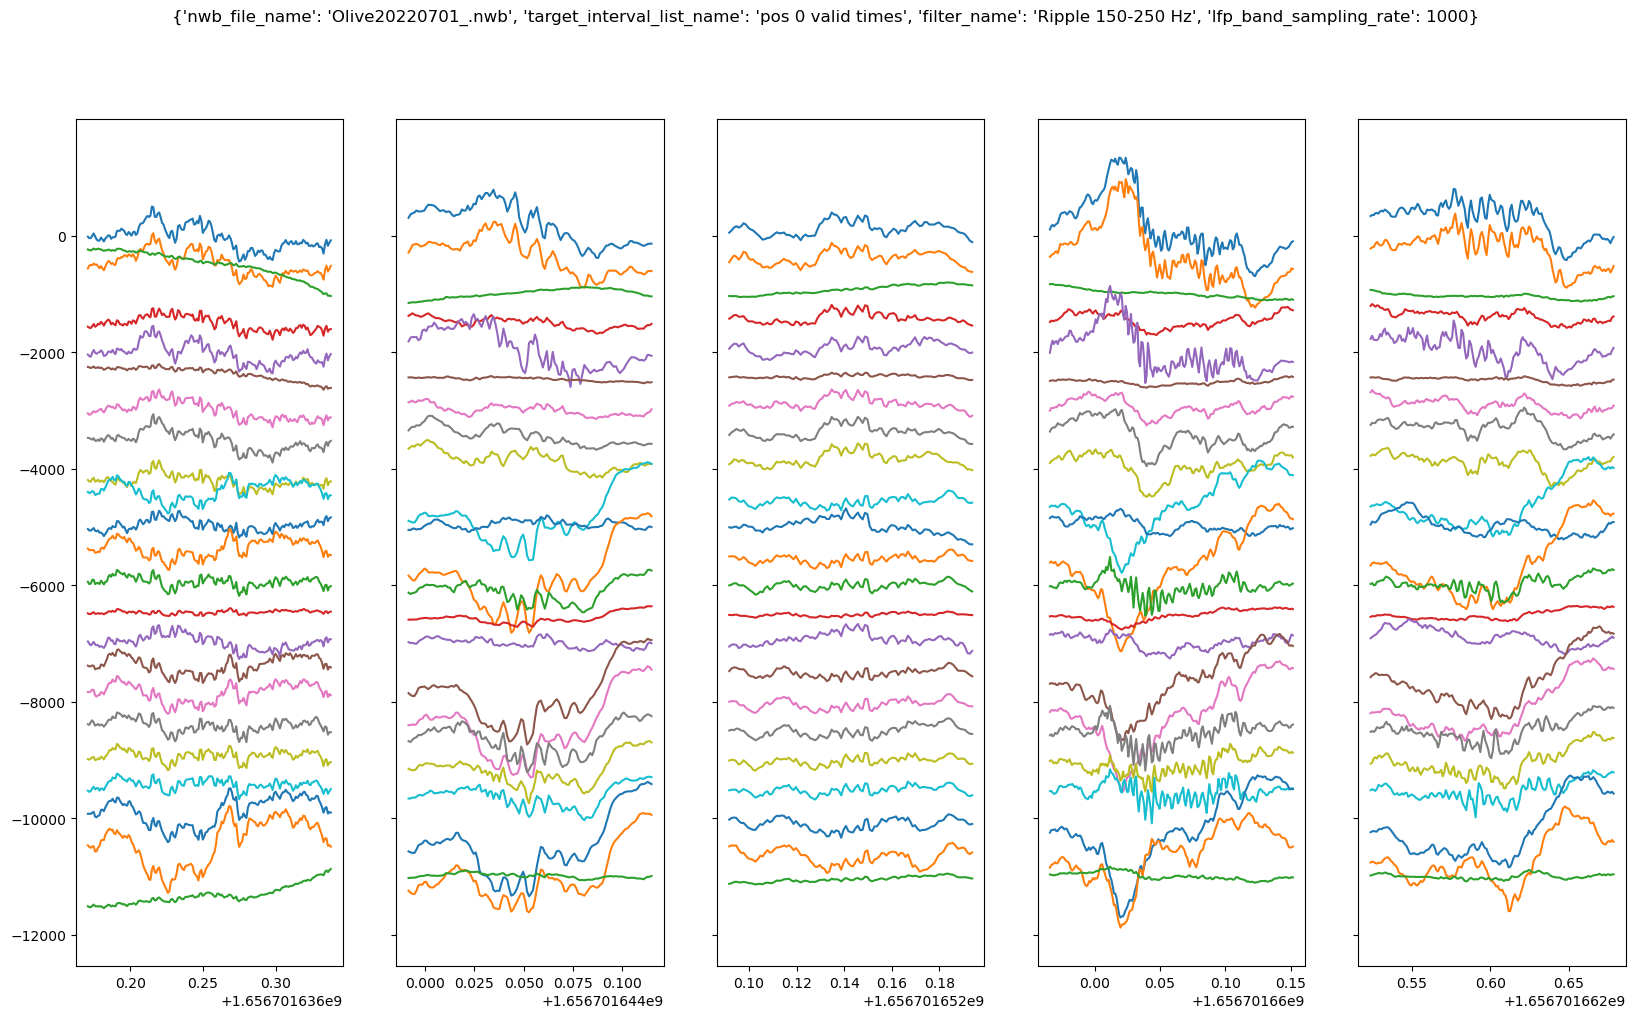

In [81]:



import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=5,figsize=(20,11),sharey=True)

for i,ripple in enumerate([100,150,200,250,300]):
    interval = ripple_df.iloc[i].values
    for j in band_df.columns:
        # ax[i].plot(band_df[(band_df.index>interval[0]-.03) & (band_df.index<interval[1]+.03)][j]-j*100)
        ax[i].plot(lfp_df[(lfp_df.index>interval[0]-.03) & (lfp_df.index<interval[1]+.03)][j]-j*500)

fig.suptitle(key)

In [47]:
band_df.columns

RangeIndex(start=0, stop=23, step=1)